# start

In [1]:
trntmstmp=1584412344
valtmstmp=1585569704

import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, valtmstmp)])


nsmpl=int(1e5)

['2020-03-17 02:32:24', '2020-03-30 12:01:44']


# setup

In [2]:
grand_total=int(1.5e8)
valid_total=int(1.4e7)
print(f'trnsz {grand_total:,}, valsz {valid_total:,}')
tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_val_min,tm_val_max=(1581552000, 1582156799)
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_val_min,tm_val_max)])

trnsz 150,000,000, valsz 14,000,000
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


In [3]:
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)


SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
# p_out=f'{HOME}/output/{PRFX}'
# Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_follower_cnt','u2_following_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)



# prep

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/val_{valtmstmp}.tsv',sep='\x01',header=None,names=cols_val,nrows=nsmpl)
lndfval=len(dfval)
print(f'{lndfval:,}')

100,000
CPU times: user 688 ms, sys: 52.9 ms, total: 741 ms
Wall time: 1.08 s


In [5]:
%%time
df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=nsmpl)
lndf=len(df)
print(f'{lndf:,}')

100,000
CPU times: user 691 ms, sys: 73.7 ms, total: 765 ms
Wall time: 1.09 s


In [6]:
def prp_tm(df, col):
    coldt=col+'_dt'
    df[coldt]=pd.to_datetime(df[col], unit='s')
    df[col+'_dayofweek']=df[coldt].dt.dayofweek
    df[col+'_day']=df[coldt].dt.day
    df[col+'_hour']=df[coldt].dt.hour

In [7]:
tags = ['hshtgs','media','links','domns',]
def prp_df(df, istrn=True):
    for tag in tags:
        df[f'has_{tag}']=df[tag].notna()
        df[tag]=df[tag].fillna('')
        df[f'lst_{tag}']=df[tag].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tag}']=df[f'lst_{tag}'].apply(len)

    df['toks']=df.toks.apply(lambda x: x.split('\t'))
    df['len_toks']=df.toks.apply(len)
    
    for col in ['tm','u1_create_tm','u2_create_tm']: prp_tm(df, col)
    if istrn:
        for col in cols_tgt_tmstmp: prp_tm(df, col)
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    if istrn:
        df['tmleft_twt']   = tm_trn_max-df.tm
        df['tmleft_u1']    = tm_trn_max-df.u1_create_tm
        df['tmleft_u2']    = tm_trn_max-df.u2_create_tm
    else:
        df['tmleft_twt']   = tm_val_max-df.tm
        df['tmleft_u1']    = tm_val_max-df.u1_create_tm
        df['tmleft_u2']    = tm_val_max-df.u2_create_tm
    
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna()
        df['enged']=df[cols_tgt].sum(1).astype(bool)
    return df

In [8]:
%%time
df = prp_df(df)

CPU times: user 1.92 s, sys: 252 ms, total: 2.18 s
Wall time: 2.19 s


In [9]:
%%time
dfval = prp_df(dfval,istrn=False)

CPU times: user 1.36 s, sys: 159 ms, total: 1.52 s
Wall time: 1.52 s


# summary

In [10]:
df.head()

toks  \
0  [101, 6417, 3410, 3398, 3184, 1909, 56910, 168...   
1  [101, 14120, 131, 120, 120, 188, 119, 11170, 1...   
2  [101, 62342, 10858, 54439, 19571, 22480, 7831,...   
3  [101, 58955, 10898, 103305, 1901, 16181, 7168,...   
4  [101, 2435, 5656, 2594, 8279, 8623, 1925, 6412...   

                                              hshtgs  \
0                                                      
1                                                      
2                                                      
3  F0F2FBE57F08E7C4326682B5EDA63E3E\tE78674D32346...   
4                                                      

                              twtid  media                             links  \
0  D4D1EBDE74F74C5DA529959AF979625C                                            
1  BFB529DAB6D384EB83E899A72AB3830D  Photo                                     
2  519078C7834E9642508F72A6C2D0F3B7         788ABAA22F1C4A9D186510C1E3E81F58   
3  52AAE9E33EFAC8C478C57B31A9E31ED1         C06B84A10A75AE4BF4A102AB45CC2ABF   
4  89C1298C55EB3D68E2784F0BFB69E6F8                                            

                              domns    twttyp  \
0                                    TopLevel   
1                                    TopLevel   
2  892B6E0BC037800B59112CFCB95E3301  TopLevel   
3  C0F5328C1D36CD4B34D1808012E18D46  TopLevel   
4                                    TopLevel   

                               lang          tm  \
0  22C448FF81263D4BAF2A176145EE9EAD  1581258144   
1  B9175601E87101A984A50F8A62A1C374  1581018910   
2  22C448FF81263D4BAF2A176145EE9EAD  1581244866   
3  22C448FF81263D4BAF2A176145EE9EAD  1581250124   
4  22C448FF81263D4BAF2A176145EE9EAD  1580958805   

                               u1id  u1_fllwer_cnt  u1_fllwing_cnt  u1_vrfed  \
0  D7EFC6D19CFB09B9A1CE4C4B0E0091F6           3517             590     False   
1  1F30A85E612A24B426013978ADB7AE46          39786           32978     False   
2  9E1FD934C376903895DEEBCC0F6AB920         141726            3232     False   
3  BEB3C337B266E2C4769065AD64724329           3044              99     False   
4  9E1FD934C376903895DEEBCC0F6AB920         141370            3235     False   

   u1_create_tm                              u2id  u2_follower_cnt  \
0    1391702737  0000006C3074607050F1339DDCB890BB            27428   
1    1322740272  000005C520010F8917EEAB6F5B6EC1C4               17   
2    1343181073  000006829BEADA9EEA695CF0C334B426                2   
3    1350921963  000006829BEADA9EEA695CF0C334B426                3   
4    1343181073  000006829BEADA9EEA695CF0C334B426                3   

   u2_following_cnt  u2_vrfed  u2_create_tm  u1_fllw_u2  reply_tm  retwt_tm  \
0               600     False    1520948869       False       NaN       NaN   
1                77     False    1569692352        True       NaN       NaN   
2                29     False    1568107028       False       NaN       NaN   
3                30     False    1568107028       False       NaN       NaN   
4                30     False    1568107028       False       NaN       NaN   

   retwt_cmmnt_tm       like_tm  has_hshtgs  \
0             NaN           NaN       False   
1             NaN           NaN       False   
2             NaN  1.581247e+09       False   
3             NaN           NaN        True   
4             NaN           NaN       False   

                                          lst_hshtgs  n_hshtgs  has_media  \
0                                                 []         0      False   
1                                                 []         0       True   
2                                                 []         0      False   
3  [F0F2FBE57F08E7C4326682B5EDA63E3E, E78674D3234...         2      False   
4                                                 []         0      False   

  lst_media  n_media  has_links                           lst_links  n_links  \
0        []        0      False                                  []        0   
1   [Pho

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   toks                      100000 non-null  object        
 1   hshtgs                    100000 non-null  object        
 2   twtid                     100000 non-null  object        
 3   media                     100000 non-null  object        
 4   links                     100000 non-null  object        
 5   domns                     100000 non-null  object        
 6   twttyp                    100000 non-null  object        
 7   lang                      100000 non-null  object        
 8   tm                        100000 non-null  int64         
 9   u1id                      100000 non-null  object        
 10  u1_fllwer_cnt             100000 non-null  int64         
 11  u1_fllwing_cnt            100000 non-null  int64         
 12  u1_

In [12]:
df.describe().T

count          mean           std           min  \
tm                        100000.0  1.581249e+09  1.714931e+05  1.580947e+09   
u1_fllwer_cnt             100000.0  1.324591e+06  6.715164e+06  1.000000e+00   
u1_fllwing_cnt            100000.0  5.545792e+03  4.771301e+04  0.000000e+00   
u1_create_tm              100000.0  1.397883e+09  1.153848e+08  1.145053e+09   
u2_follower_cnt           100000.0  7.874366e+02  1.633006e+04  0.000000e+00   
u2_following_cnt          100000.0  6.117112e+02  1.568890e+03  1.000000e+00   
u2_create_tm              100000.0  1.453650e+09  1.010893e+08  1.163296e+09   
reply_tm                    2754.0  1.581267e+09  1.719675e+05  1.580948e+09   
retwt_tm                   11211.0  1.581257e+09  1.699639e+05  1.580948e+09   
retwt_cmmnt_tm               801.0  1.581261e+09  1.723329e+05  1.580951e+09   
like_tm                    43929.0  1.581261e+09  1.685999e+05  1.580948e+09   
n_hshtgs                  100000.0  3.821500e-01  1.073864e+00  0.000000e+00   
n_media                   100000.0  5.185400e-01  8.303512e-01  0.000000e+00   
n_links                   100000.0  1.399000e-01  3.663732e-01  0.000000e+00   
n_domns                   100000.0  1.399000e-01  3.663732e-01  0.000000e+00   
len_toks                  100000.0  4.662853e+01  2.903180e+01  2.000000e+00   
tm_dayofweek              100000.0  3.027510e+00  2.020746e+00  0.000000e+00   
tm_day                    100000.0  8.971780e+00  1.966958e+00  6.000000e+00   
tm_hour                   100000.0  1.193252e+01  6.931957e+00  0.000000e+00   
u1_create_tm_dayofweek    100000.0  3.058620e+00  2.044922e+00  0.000000e+00   
u1_create_tm_day          100000.0  1.570099e+01  8.820318e+00  1.000000e+00   
u1_create_tm_hour         100000.0  1.220338e+01  6.833885e+00  0.000000e+00   
u2_create_tm_dayofweek    100000.0  3.028610e+00  1.988882e+00  0.000000e+00   
u2_create_tm_day          100000.0  1.566908e+01  8.760171e+00  1.000000e+00   
u2_create_tm_hour         100000.0  1.209466e+01  6.936858e+00  0.000000e+00   
retwt_tm_dayofweek         11211.0  3.032647e+00  2.036510e+00  0.000000e+00   
retwt_tm_day               11211.0  9.074659e+00  1.947035e+00  6.000000e+00   
retwt_tm_hour              11211.0  1.169396e+01  6.806822e+00  0.000000e+00   
reply_tm_dayofweek          2754.0  2.932099e+00  2.036027e+00  0.000000e+00   
reply_tm_day                2754.0  9.175381e+00  1.967987e+00  6.000000e+00   
reply_tm_hour               2754.0  1.225527e+01  6.904084e+00  0.000000e+00   
like_tm_dayofweek          43929.0  3.016276e+00  2.050122e+00  0.000000e+00   
like_tm_day                43929.0  9.111771e+00  1.933911e+00  6.000000e+00   
like_tm_hour               43929.0  1.202820e+01  6.943229e+00  0.000000e+00   
retwt_cmmnt_tm_dayofweek     801.0  2.987516e+00  2.035889e+00  0.000000e+00   
retwt_cmmnt_tm_day           801.0  9.107366e+00  1.983925e+00  6.000000e+00   
retwt_cmmnt_tm_hour          801.0  1.204744e+01  6.945700e+00  0.000000e+00   
tmdlta_u2u1               100000.0  5.576705e+07  1.274500e+08 -3.912338e+08   
tmdlta_twtu1              100000.0  1.833653e+08  1.153874e+08  2.508240e+06   
tmdlta_twtu2              100000.0  1.275982e+08  1.010912e+08  2.104260e+06   
tmleft_twt                100000.0  3.033319e+05  1.714931e+05  9.000000e+00   
tmleft_u1                 100000.0  1.836686e+08  1.153848e+08  2.614897e+06   
tmleft_u2                 100000.0  1.279016e+08  1.010893e+08  2.592276e+06   

                                   25%           50%           75%  \
tm                        1.581106e+09  1.581251e+09  1.581393e+09   
u1_fllwer_cnt             1.124000e+03  1.264100e+04  1.921700e+05   
u1_fllwing_cnt            1.980000e+02  5.380000e+02  1.419000e+03   
u1_create_tm              1.295124e+09  1.398570e+09  1.506740e+09   
u2_follower_cnt           4.400000e+01  1.570000e+02  4.670000e+02   
u2_following_cnt          1.290000e+02  2.820000e+02  6.090000e+02   
u2_create_tm      

In [13]:
for col,dtyp in dict(df.dtypes).items():
    if dtyp=='bool':
        print(col)

u1_vrfed
u2_vrfed
u1_fllw_u2
has_hshtgs
has_media
has_links
has_domns
retwt
reply
like
retwt_cmmnt
enged


In [14]:
df.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'has_hshtgs', 'lst_hshtgs', 'n_hshtgs',
       'has_media', 'lst_media', 'n_media', 'has_links', 'lst_links',
       'n_links', 'has_domns', 'lst_domns', 'n_domns', 'len_toks', 'tm_dt',
       'tm_dayofweek', 'tm_day', 'tm_hour', 'u1_create_tm_dt',
       'u1_create_tm_dayofweek', 'u1_create_tm_day', 'u1_create_tm_hour',
       'u2_create_tm_dt', 'u2_create_tm_dayofweek', 'u2_create_tm_day',
       'u2_create_tm_hour', 'retwt_tm_dt', 'retwt_tm_dayofweek',
       'retwt_tm_day', 'retwt_tm_hour', 'reply_tm_dt', 'reply_tm_dayofweek',
       'reply_tm_day', 'reply_tm_hour', 'like_tm_dt', 'like_tm_dayofweek',
       'like_tm_day', 'like_tm_hour', 'retwt_cmmnt_tm_dt',
   

## catish

In [15]:
for col in df.columns:
    try:
        print(col, df[col].nunique())
    except:
        pass

hshtgs 14683
twtid 97829
media 8
links 12811
domns 4670
twttyp 3
lang 59
tm 89401
u1id 77525
u1_fllwer_cnt 44542
u1_fllwing_cnt 11354
u1_vrfed 2
u1_create_tm 77513
u2id 65571
u2_follower_cnt 4891
u2_following_cnt 4242
u2_vrfed 2
u2_create_tm 65569
u1_fllw_u2 2
reply_tm 2752
retwt_tm 11097
retwt_cmmnt_tm 801
like_tm 42180
has_hshtgs 2
n_hshtgs 27
has_media 2
n_media 5
has_links 2
n_links 7
has_domns 2
n_domns 7
len_toks 227
tm_dt 89401
tm_dayofweek 7
tm_day 7
tm_hour 24
u1_create_tm_dt 77513
u1_create_tm_dayofweek 7
u1_create_tm_day 31
u1_create_tm_hour 24
u2_create_tm_dt 65569
u2_create_tm_dayofweek 7
u2_create_tm_day 31
u2_create_tm_hour 24
retwt_tm_dt 11097
retwt_tm_dayofweek 7
retwt_tm_day 7
retwt_tm_hour 24
reply_tm_dt 2752
reply_tm_dayofweek 7
reply_tm_day 7
reply_tm_hour 24
like_tm_dt 42180
like_tm_dayofweek 7
like_tm_day 7
like_tm_hour 24
retwt_cmmnt_tm_dt 801
retwt_cmmnt_tm_dayofweek 7
retwt_cmmnt_tm_day 7
retwt_cmmnt_tm_hour 24
tmdlta_u2u1 98461
tmdlta_twtu1 97800
tmdlta_twtu2

In [16]:
cols_catish=['media', 'twttyp', 'lang', 'u1_vrfed', 'u2_vrfed', 'u1_fllw_u2', 'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_links', 'n_links', 'has_domns', 'n_domns', 'tm_dayofweek', 'tm_day', 'tm_hour', 'u1_create_tm_dayofweek', 'u1_create_tm_day', 'u1_create_tm_hour', 'u2_create_tm_dayofweek', 'u2_create_tm_day', 'u2_create_tm_hour', ]

In [17]:
def show_catish(col):
    dfperc=pd.DataFrame(df[col].value_counts()/lndf).reset_index()
    dfperc_val=pd.DataFrame(dfval[col].value_counts(dropna=False)/lndfval).reset_index()
    dfj = pd.merge(dfperc, dfperc_val, how='outer', on='index',suffixes=('_trn', '_val'))
    dftgt=(df.groupby(col)[cols_tgt+['enged']].mean()).reset_index()
    dfshow=pd.merge(dfj, dftgt, how='outer',left_on='index', right_on=col).drop(columns=[col])
    return dfshow

In [18]:
for col in cols_catish:
    display(show_catish(col).head(20))

index  media_trn  media_val     retwt     reply  \
0                                0.61865    0.63068  0.107896  0.030243   
1                       Photo    0.18397    0.18067  0.092569  0.026580   
2                       Video    0.10851    0.10383  0.146438  0.018155   
3                Photo\tPhoto    0.04125    0.03833  0.143758  0.024000   
4  Photo\tPhoto\tPhoto\tPhoto    0.02317    0.02242  0.146741  0.019853   
5         Photo\tPhoto\tPhoto    0.01321    0.01222  0.129447  0.018925   
6                         GIF    0.01123    0.01185  0.124666  0.024043   
7                Video\tVideo    0.00001        NaN  0.000000  0.000000   

       like  retwt_cmmnt     enged  
0  0.405835     0.007791  0.479835  
1  0.477904     0.006197  0.534435  
2  0.476915     0.011059  0.555893  
3  0.565818     0.010909  0.643636  
4  0.551575     0.007769  0.629262  
5  0.527631     0.009841  0.606359  
6  0.486198     0.008014  0.563669  
7  0.000000     0.000000  0.000000

index  twttyp_trn  twttyp_val     retwt     reply      like  \
0  TopLevel     0.56862     0.57330  0.094844  0.038251  0.520981   
1   Retweet     0.34292     0.33598  0.144407  0.007932  0.294763   
2     Quote     0.08846     0.09072  0.097897  0.034705  0.474452   

   retwt_cmmnt     enged  
0     0.008090  0.583078  
1     0.007407  0.384988  
2     0.009835  0.535722

index  lang_trn  lang_val     retwt     reply  \
0   D3164C7FBCF2565DDF915B1B3AEFB1DC   0.41179   0.43437  0.105272  0.025061   
1   22C448FF81263D4BAF2A176145EE9EAD   0.16127   0.15594  0.071681  0.026477   
2   06D61DCBBE938971E1EA0C38BD9B5446   0.08887   0.08868  0.112861  0.029481   
3   ECED8A16BE2A5E8871FD55F4842F16B1   0.06895   0.07118  0.120522  0.035678   
4   B9175601E87101A984A50F8A62A1C374   0.05348   0.05014  0.095363  0.018512   
5   4DC22C3F31C5C43721E6B5815A595ED6   0.03288   0.03072  0.047141  0.017032   
6   167115458A0DBDFF7E9C0C53A83BAC9B   0.03161   0.02852  0.094907  0.050933   
7   125C57F4FA6D4E110983FB11B52EFD4E   0.02410   0.02117  0.232365  0.016183   
8   022EC308651FACB02794A8147AEE1B78   0.02361   0.02046  0.492588  0.020330   
9   FA3F382BC409C271E3D6EAF8BE4648DD   0.02152   0.02115  0.141264  0.028810   
10  9BF3403E0EB7EA8A256DA9019C0B0716   0.01942   0.01665  0.110711  0.055613   
11  2996EB2FE8162C076D070A4C8D6532CD   0.00916   0.00837  0.124454  0.027293   
12  975B38F44D65EE42A547283787FF5A21   0.00862   0.00928  0.194896  0.023202   
13  3E16B11B7ADE3A22DDFC4423FBCEAD5D   0.00568   0.00510  0.054577  0.038732   
14  3820C29CBCA409A33BADF68852057C4A   0.00515   0.00455  0.048544  0.048544   
15  FF60A88F53E63000266F8B9149E35AD9   0.00482   0.00540  0.060166  0.053942   
16  717293301FE296B0B61950D041485825   0.00439   0.00516  0.061503  0.036446   
17  AEF22666801F0A5846D853B9CEB2E327   0.00258   0.00192  0.139535  0.031008   
18  9ECD42BC079C20F156F53CB3B99E600E   0.00250   0.00240  0.100000  0.044000   
19  76B8A9C3013AE6414A3E6012413CDC3B   0.00234   0.00244  0.111111  0.042735   

        like  retwt_cmmnt     enged  
0   0.435246     0.009034  0.493820  
1   0.468593     0.003162  0.509642  
2   0.397434     0.009790  0.474513  
3   0.450616     0.012908  0.532560  
4   0.461294     0.008040  0.516829  
5   0.549574     0.002129  0.576642  
6   0.419488     0.009174  0.506485  
7   0.444813     0.009544  0.600415  
8   0.232529     0.006353  0.663702  
9   0.386152     0.007900  0.479554  
10  0.328012     0.009784  0.451081  
11  0.496725     0.012009  0.573144  
12  0.534803     0.012761  0.595128  
13  0.658451     0.001761  0.683099  
14  0.516505     0.000000  0.547573  
15  0.431535     0.002075  0.479253  
16  0.428246     0.009112  0.478360  
17  0.585271     0.003876  0.643411  
18  0.448000     0.016000  0.500000  
19  0.423077     0.008547  0.508547

index  u1_vrfed_trn  u1_vrfed_val     retwt     reply      like  \
0  False       0.75083       0.73356  0.125927  0.030873  0.457560   
1   True       0.24917       0.26644  0.070474  0.017498  0.384236   

   retwt_cmmnt     enged  
0     0.008697  0.540269  
1     0.005940  0.422643

index  u2_vrfed_trn  u2_vrfed_val     retwt     reply      like  \
0  False       0.99794       0.99642  0.112091  0.027547  0.439455   
1   True       0.00206       0.00358  0.121359  0.024272  0.359223   

   retwt_cmmnt     enged  
0     0.007976  0.511063  
1     0.024272  0.461165

index  u1_fllw_u2_trn  u1_fllw_u2_val     retwt     reply      like  \
0  False         0.64044         0.64645  0.101821  0.018159  0.419774   
1   True         0.35956         0.35355  0.130437  0.044249  0.474052   

   retwt_cmmnt     enged  
0     0.006074  0.479077  
1     0.011458  0.567749

index  has_hshtgs_trn  has_hshtgs_val     retwt     reply      like  \
0  False         0.80501         0.79646  0.109564  0.029838  0.449137   
1   True         0.19499         0.20354  0.122622  0.018052  0.398636   

   retwt_cmmnt     enged  
0      0.00831  0.522267  
1      0.00677  0.464280

index  n_hshtgs_trn  n_hshtgs_val     retwt     reply      like  \
0       0       0.80501       0.79646  0.109564  0.029838  0.449137   
1       1       0.10877       0.11467  0.115473  0.018663  0.393215   
2       2       0.04363       0.04299  0.120101  0.018336  0.375888   
3       3       0.01994       0.02066  0.160983  0.020562  0.428285   
4       4       0.00965       0.01055  0.134715  0.011399  0.424870   
5       5       0.00547       0.00572  0.117002  0.016453  0.488117   
6       6       0.00281       0.00337  0.128114  0.003559  0.441281   
7       7       0.00155       0.00204  0.103226  0.012903  0.406452   
8       8       0.00118       0.00130  0.127119  0.016949  0.398305   
9       9       0.00062       0.00074  0.145161  0.016129  0.483871   
10     10       0.00035       0.00048  0.171429  0.000000  0.400000   
11     11       0.00027       0.00030  0.111111  0.074074  0.444444   
12     12       0.00022       0.00023  0.136364  0.000000  0.545455   
13     13       0.00016       0.00015  0.187500  0.000000  0.312500   
14     14       0.00008       0.00011  0.000000  0.000000  0.500000   
15     15       0.00007       0.00004  0.142857  0.000000  0.285714   
16     16       0.00006       0.00008  0.000000  0.000000  0.500000   
17     18       0.00003       0.00001  0.000000  0.000000  0.666667   
18     19       0.00003       0.00003  0.333333  0.000000  0.333333   
19     20       0.00003           NaN  0.000000  0.000000  0.333333   

    retwt_cmmnt     enged  
0      0.008310  0.522267  
1      0.007263  0.457111  
2      0.006647  0.443044  
3      0.007021  0.508526  
4      0.003109  0.487047  
5      0.001828  0.531993  
6      0.010676  0.508897  
7      0.006452  0.464516  
8      0.008475  0.474576  
9      0.000000  0.580645  
10     0.000000  0.457143  
11     0.000000  0.481481  
12     0.045455  0.545455  
13     0.000000  0.375000  
14     0.000000  0.500000  
15     0.000000  0.285714  
16     0.000000  0.500000  
17     0.000000  0.666667  
18     0.000000  0.333333  
19     0.000000  0.333333

index  has_media_trn  has_media_val     retwt     reply      like  \
0  False        0.61865        0.63068  0.107896  0.030243  0.405835   
1   True        0.38135        0.36932  0.118946  0.023155  0.493562   

   retwt_cmmnt     enged  
0     0.007791  0.479835  
1     0.008365  0.561453

index  n_media_trn  n_media_val     retwt     reply      like  retwt_cmmnt  \
0      0      0.61865      0.63068  0.107896  0.030243  0.405835     0.007791   
1      1      0.30371      0.29635  0.113003  0.023476  0.477857     0.008001   
2      2      0.04126      0.03833  0.143723  0.023994  0.565681     0.010906   
3      4      0.02317      0.02242  0.146741  0.019853  0.551575     0.007769   
4      3      0.01321      0.01222  0.129447  0.018925  0.527631     0.009841   

      enged  
0  0.479835  
1  0.543183  
2  0.643480  
3  0.629262  
4  0.606359

index  has_links_trn  has_links_val     retwt     reply      like  \
0  False        0.86532        0.85769  0.117147  0.029550  0.467261   
1   True        0.13468        0.14231  0.079745  0.014627  0.259578   

   retwt_cmmnt     enged  
0     0.008321  0.543313  
1     0.006014  0.303089

index  n_links_trn  n_links_val     retwt     reply      like  retwt_cmmnt  \
0      0      0.86532      0.85769  0.117147  0.029550  0.467261     0.008321   
1      1      0.13054      0.13795  0.078673  0.014708  0.258235     0.006052   
2      2      0.00345      0.00359  0.104348  0.011594  0.292754     0.002899   
3      3      0.00044      0.00045  0.204545  0.022727  0.318182     0.022727   
4      4      0.00017      0.00023  0.000000  0.000000  0.294118     0.000000   
5      5      0.00006      0.00004  0.333333  0.000000  0.666667     0.000000   
6      8      0.00002      0.00001  0.000000  0.000000  0.500000     0.000000   
7      6          NaN      0.00003       NaN       NaN       NaN          NaN   
8      9          NaN      0.00001       NaN       NaN       NaN          NaN   

      enged  
0  0.543313  
1  0.301057  
2  0.353623  
3  0.431818  
4  0.294118  
5  0.833333  
6  0.500000  
7       NaN  
8       NaN

index  has_domns_trn  has_domns_val     retwt     reply      like  \
0  False        0.86532        0.85769  0.117147  0.029550  0.467261   
1   True        0.13468        0.14231  0.079745  0.014627  0.259578   

   retwt_cmmnt     enged  
0     0.008321  0.543313  
1     0.006014  0.303089

index  n_domns_trn  n_domns_val     retwt     reply      like  retwt_cmmnt  \
0      0      0.86532      0.85769  0.117147  0.029550  0.467261     0.008321   
1      1      0.13054      0.13795  0.078673  0.014708  0.258235     0.006052   
2      2      0.00345      0.00359  0.104348  0.011594  0.292754     0.002899   
3      3      0.00044      0.00045  0.204545  0.022727  0.318182     0.022727   
4      4      0.00017      0.00023  0.000000  0.000000  0.294118     0.000000   
5      5      0.00006      0.00004  0.333333  0.000000  0.666667     0.000000   
6      8      0.00002      0.00001  0.000000  0.000000  0.500000     0.000000   
7      6          NaN      0.00003       NaN       NaN       NaN          NaN   
8      9          NaN      0.00001       NaN       NaN       NaN          NaN   

      enged  
0  0.543313  
1  0.301057  
2  0.353623  
3  0.431818  
4  0.294118  
5  0.833333  
6  0.500000  
7       NaN  
8       NaN

index  tm_dayofweek_trn  tm_dayofweek_val     retwt     reply      like  \
0      5           0.15082           0.14714  0.121469  0.026455  0.458626   
1      0           0.14762           0.15339  0.111638  0.028384  0.444994   
2      6           0.14570           0.14255  0.110913  0.027660  0.451270   
3      4           0.14546           0.13987  0.111027  0.025987  0.447477   
4      1           0.14084           0.14269  0.110267  0.028401  0.435956   
5      3           0.13741           0.14455  0.113383  0.027145  0.431919   
6      2           0.13215           0.12981  0.105108  0.028907  0.399849   

   retwt_cmmnt     enged  
0     0.007957  0.533417  
1     0.008264  0.517410  
2     0.007824  0.522032  
3     0.007150  0.520830  
4     0.008094  0.505112  
5     0.008660  0.504257  
6     0.008173  0.468256

index  tm_day_trn  tm_day_val     retwt     reply      like  retwt_cmmnt  \
0       8     0.15082         NaN  0.121469  0.026455  0.458626     0.007957   
1      10     0.14762         NaN  0.111638  0.028384  0.444994     0.008264   
2       9     0.14570         NaN  0.110913  0.027660  0.451270     0.007824   
3       7     0.14546         NaN  0.111027  0.025987  0.447477     0.007150   
4      11     0.14084         NaN  0.110267  0.028401  0.435956     0.008094   
5       6     0.13741         NaN  0.113383  0.027145  0.431919     0.008660   
6      12     0.13215         NaN  0.105108  0.028907  0.399849     0.008173   
7      17         NaN     0.15339       NaN       NaN       NaN          NaN   
8      15         NaN     0.14714       NaN       NaN       NaN          NaN   
9      13         NaN     0.14455       NaN       NaN       NaN          NaN   
10     18         NaN     0.14269       NaN       NaN       NaN          NaN   
11     16         NaN     0.14255       NaN       NaN       NaN          NaN   
12     14         NaN     0.13987       NaN       NaN       NaN          NaN   
13     19         NaN     0.12981       NaN       NaN       NaN          NaN   

       enged  
0   0.533417  
1   0.517410  
2   0.522032  
3   0.520830  
4   0.505112  
5   0.504257  
6   0.468256  
7        NaN  
8        NaN  
9        NaN  
10       NaN  
11       NaN  
12       NaN  
13       NaN

index  tm_hour_trn  tm_hour_val     retwt     reply      like  \
0      15      0.05181      0.05246  0.111948  0.030303  0.429454   
1      14      0.05099      0.05066  0.125907  0.027849  0.433811   
2      13      0.04859      0.04841  0.120601  0.029636  0.441449   
3      16      0.04813      0.04962  0.112404  0.027218  0.427800   
4      17      0.04629      0.04757  0.104342  0.028948  0.413048   
5      12      0.04545      0.04382  0.118592  0.029923  0.452145   
6      20      0.04445      0.04214  0.096288  0.026322  0.432171   
7      22      0.04445      0.04347  0.092238  0.027447  0.451744   
8       3      0.04423      0.04772  0.129776  0.023740  0.473887   
9      18      0.04357      0.04451  0.098921  0.029608  0.420243   
10      2      0.04337      0.04464  0.109062  0.032280  0.452848   
11     21      0.04283      0.04111  0.095027  0.028018  0.446883   
12     19      0.04270      0.04359  0.098361  0.029508  0.429977   
13     23      0.04226      0.04217  0.104117  0.026976  0.440133   
14      0      0.04171      0.04198  0.105011  0.026133  0.449532   
15      1      0.04167      0.04302  0.114471  0.027838  0.448284   
16     11      0.04164      0.03993  0.121278  0.026417  0.431796   
17     10      0.03718      0.03597  0.115923  0.026896  0.430877   
18      4      0.03694      0.03759  0.126692  0.027342  0.441256   
19      9      0.03483      0.03594  0.115992  0.023543  0.435831   

    retwt_cmmnt     enged  
0      0.008879  0.504343  
1      0.007256  0.515199  
2      0.008232  0.523359  
3      0.008934  0.493455  
4      0.008641  0.482178  
5      0.005941  0.530033  
6      0.007649  0.495613  
7      0.005849  0.507987  
8      0.009948  0.550531  
9      0.009640  0.479917  
10     0.008070  0.525017  
11     0.007238  0.499883  
12     0.007728  0.495550  
13     0.007336  0.502366  
14     0.007193  0.513066  
15     0.011039  0.525798  
16     0.008646  0.511287  
17     0.007262  0.506724  
18     0.010287  0.526530  
19     0.007178  0.510479

index  u1_create_tm_dayofweek_trn  u1_create_tm_dayofweek_val     retwt  \
0      5                     0.15783                     0.15885  0.107457   
1      6                     0.15233                     0.15407  0.106873   
2      0                     0.14938                     0.14574  0.111260   
3      4                     0.14512                     0.14983  0.111080   
4      1                     0.14113                     0.14118  0.114504   
5      2                     0.12875                     0.12726  0.116816   
6      3                     0.12546                     0.12307  0.119002   

      reply      like  retwt_cmmnt     enged  
0  0.024647  0.431160     0.008173  0.497877  
1  0.025799  0.432613     0.006893  0.500558  
2  0.026911  0.439751     0.009841  0.507096  
3  0.029700  0.433434     0.008062  0.510061  
4  0.027634  0.432084     0.007865  0.507121  
5  0.027883  0.457165     0.008155  0.531262  
6  0.031086  0.453611     0.006934  0.529173

index  u1_create_tm_day_trn  u1_create_tm_day_val     retwt     reply  \
0      27               0.03605               0.03347  0.115118  0.021637   
1      10               0.03461               0.03625  0.106906  0.023404   
2       1               0.03401               0.03464  0.097618  0.028227   
3       9               0.03389               0.03403  0.103275  0.029212   
4       6               0.03386               0.03268  0.105434  0.025399   
5      19               0.03379               0.03270  0.118970  0.029595   
6       7               0.03377               0.03258  0.110453  0.028131   
7      25               0.03366               0.03329  0.117350  0.027926   
8       2               0.03347               0.03274  0.120108  0.023902   
9      15               0.03343               0.03353  0.111277  0.029913   
10     16               0.03330               0.03285  0.102102  0.027928   
11     23               0.03326               0.03311  0.111245  0.026158   
12     21               0.03318               0.03208  0.109403  0.029837   
13     24               0.03318               0.03431  0.108800  0.028933   
14     14               0.03296               0.03288  0.100121  0.027002   
15      5               0.03295               0.03190  0.116237  0.029742   
16     18               0.03272               0.03253  0.113081  0.025061   
17      3               0.03265               0.03307  0.120368  0.025421   
18     26               0.03247               0.03208  0.121035  0.025870   
19     28               0.03243               0.03166  0.116250  0.028369   

        like  retwt_cmmnt     enged  
0   0.460194     0.008877  0.527878  
1   0.436868     0.007801  0.509390  
2   0.422817     0.006763  0.486622  
3   0.429330     0.010918  0.496902  
4   0.463969     0.008565  0.528352  
5   0.428529     0.010654  0.507251  
6   0.431744     0.006811  0.504886  
7   0.412953     0.007130  0.490790  
8   0.418285     0.008963  0.491186  
9   0.444511     0.008376  0.515405  
10  0.427628     0.004805  0.498799  
11  0.434756     0.009321  0.510222  
12  0.464135     0.006932  0.529536  
13  0.463532     0.010549  0.533755  
14  0.431129     0.006371  0.497573  
15  0.436722     0.008194  0.509863  
16  0.448655     0.008252  0.526589  
17  0.444410     0.007963  0.521286  
18  0.448722     0.007699  0.525408  
19  0.438791     0.007092  0.506938

index  u1_create_tm_hour_trn  u1_create_tm_hour_val     retwt     reply  \
0      15                0.05436                0.05350  0.116262  0.029433   
1      16                0.05189                0.05289  0.107535  0.029678   
2      14                0.05170                0.05085  0.118569  0.026306   
3      13                0.04975                0.04965  0.115779  0.028342   
4      17                0.04926                0.05281  0.114089  0.029639   
5      20                0.04616                0.04778  0.101386  0.025347   
6      19                0.04598                0.04742  0.096346  0.028926   
7      18                0.04567                0.04600  0.106416  0.027808   
8      22                0.04469                0.04585  0.104945  0.028194   
9      12                0.04469                0.04387  0.122175  0.029984   
10     21                0.04404                0.04617  0.102180  0.027929   
11     23                0.04128                0.04167  0.107316  0.028585   
12     11                0.04051                0.03835  0.105406  0.023698   
13      0                0.03980                0.04048  0.101759  0.029146   
14      2                0.03880                0.03997  0.112113  0.029124   
15      1                0.03776                0.03878  0.105667  0.029396   
16      3                0.03771                0.03714  0.122249  0.024927   
17     10                0.03690                0.03507  0.120325  0.022764   
18      9                0.03597                0.03425  0.123158  0.024187   
19      4                0.03594                0.03484  0.110462  0.027824   

        like  retwt_cmmnt     enged  
0   0.424209     0.008462  0.501472  
1   0.424937     0.009058  0.493544  
2   0.445455     0.006576  0.522437  
3   0.442814     0.004824  0.524020  
4   0.446001     0.011368  0.517052  
5   0.432409     0.008016  0.492418  
6   0.426925     0.009134  0.486081  
7   0.439019     0.010510  0.509306  
8   0.439919     0.008951  0.501454  
9   0.438353     0.007608  0.525173  
10  0.457539     0.009991  0.516122  
11  0.453246     0.007752  0.519622  
12  0.433720     0.003209  0.501605  
13  0.439196     0.007538  0.505779  
14  0.432732     0.007732  0.503351  
15  0.439089     0.008739  0.510858  
16  0.440997     0.011668  0.516043  
17  0.427642     0.006233  0.507046  
18  0.445093     0.006672  0.518766  
19  0.442960     0.006956  0.512799

index  u2_create_tm_dayofweek_trn  u2_create_tm_dayofweek_val     retwt  \
0      3                     0.14792                     0.14873  0.122296   
1      5                     0.14404                     0.13974  0.112955   
2      6                     0.14400                     0.14589  0.109167   
3      4                     0.14396                     0.14195  0.105515   
4      2                     0.14182                     0.14297  0.114229   
5      1                     0.14117                     0.13854  0.109513   
6      0                     0.13709                     0.14218  0.110730   

      reply      like  retwt_cmmnt     enged  
0  0.030287  0.443956     0.008991  0.522580  
1  0.027978  0.433768     0.007220  0.505415  
2  0.026250  0.443194     0.008056  0.510625  
3  0.027994  0.438247     0.008197  0.505765  
4  0.025807  0.441334     0.007968  0.513820  
5  0.026564  0.438549     0.006871  0.509315  
6  0.027792  0.435699     0.008753  0.508790

index  u2_create_tm_day_trn  u2_create_tm_day_val     retwt     reply  \
0      15               0.03447               0.03326  0.105019  0.026400   
1      14               0.03444               0.03420  0.115273  0.026713   
2       8               0.03394               0.03332  0.113730  0.031526   
3      27               0.03381               0.03348  0.110914  0.025436   
4      19               0.03363               0.03338  0.118941  0.028843   
5       7               0.03352               0.03383  0.121718  0.028640   
6       6               0.03342               0.03402  0.105326  0.023938   
7      25               0.03337               0.03186  0.113875  0.034762   
8      17               0.03328               0.03425  0.115986  0.035457   
9       5               0.03324               0.03236  0.120337  0.025271   
10      3               0.03313               0.03247  0.109870  0.025355   
11     18               0.03307               0.03524  0.109162  0.024191   
12     21               0.03295               0.03257  0.104097  0.026404   
13      2               0.03286               0.03272  0.112295  0.029519   
14     13               0.03282               0.03214  0.117307  0.027727   
15     20               0.03282               0.03209  0.108775  0.024071   
16     24               0.03271               0.03256  0.107307  0.026597   
17     16               0.03270               0.03274  0.108257  0.022936   
18     12               0.03265               0.03480  0.110260  0.026340   
19      1               0.03258               0.03187  0.111418  0.027317   

        like  retwt_cmmnt     enged  
0   0.415434     0.008703  0.486800  
1   0.426829     0.009292  0.505517  
2   0.436358     0.009428  0.512080  
3   0.444247     0.008577  0.515824  
4   0.436515     0.007731  0.514422  
5   0.443914     0.007458  0.525358  
6   0.453920     0.007780  0.515859  
7   0.455499     0.008391  0.531016  
8   0.459736     0.004507  0.536959  
9   0.435620     0.008123  0.505716  
10  0.465741     0.007546  0.525807  
11  0.449652     0.006955  0.517690  
12  0.446737     0.005766  0.513505  
13  0.455873     0.006086  0.525867  
14  0.434186     0.008531  0.515235  
15  0.429311     0.007008  0.501523  
16  0.438092     0.009477  0.501376  
17  0.437003     0.007645  0.493884  
18  0.429709     0.009801  0.489433  
19  0.430632     0.009515  0.511664

index  u2_create_tm_hour_trn  u2_create_tm_hour_val     retwt     reply  \
0      14                0.05266                0.05230  0.127421  0.025066   
1      16                0.05159                0.05120  0.110293  0.026168   
2      13                0.05010                0.04803  0.126946  0.025150   
3      15                0.04968                0.05127  0.120773  0.027979   
4      17                0.04738                0.04677  0.101520  0.030393   
5      21                0.04526                0.04593  0.103624  0.031153   
6      18                0.04503                0.04655  0.103487  0.027315   
7      20                0.04488                0.04733  0.094029  0.025624   
8      19                0.04486                0.04481  0.089835  0.021177   
9      22                0.04467                0.04486  0.104097  0.026416   
10     23                0.04375                0.04411  0.111543  0.029943   
11     12                0.04361                0.04223  0.120844  0.024077   
12      2                0.04360                0.04327  0.115826  0.027752   
13      1                0.04190                0.04339  0.104057  0.032458   
14      0                0.04170                0.04367  0.102398  0.029257   
15     11                0.04062                0.03898  0.143033  0.031265   
16      3                0.03959                0.04179  0.104319  0.029553   
17     10                0.03610                0.03412  0.111357  0.031856   
18      4                0.03538                0.03608  0.119842  0.027699   
19      9                0.03319                0.03191  0.114794  0.023802   

        like  retwt_cmmnt     enged  
0   0.434106     0.009875  0.511774  
1   0.448924     0.008723  0.519481  
2   0.445709     0.008782  0.525948  
3   0.433172     0.008454  0.516908  
4   0.437104     0.006754  0.498945  
5   0.438135     0.008396  0.502872  
6   0.438152     0.008439  0.503442  
7   0.436497     0.009135  0.495766  
8   0.444048     0.006910  0.495542  
9   0.447504     0.008507  0.508619  
10  0.432000     0.008914  0.496000  
11  0.434763     0.005274  0.516854  
12  0.435550     0.008257  0.513991  
13  0.434606     0.011456  0.502387  
14  0.441966     0.009113  0.509113  
15  0.445101     0.006893  0.538405  
16  0.441273     0.008335  0.507704  
17  0.449307     0.004709  0.526593  
18  0.440927     0.006501  0.514132  
19  0.438385     0.004519  0.514613

## WARNING: tm_day should not be a feature!

In [20]:
show_catish('tm_day')

index  tm_day_trn  tm_day_val     retwt     reply      like  retwt_cmmnt  \
0       8     0.15082         NaN  0.121469  0.026455  0.458626     0.007957   
1      10     0.14762         NaN  0.111638  0.028384  0.444994     0.008264   
2       9     0.14570         NaN  0.110913  0.027660  0.451270     0.007824   
3       7     0.14546         NaN  0.111027  0.025987  0.447477     0.007150   
4      11     0.14084         NaN  0.110267  0.028401  0.435956     0.008094   
5       6     0.13741         NaN  0.113383  0.027145  0.431919     0.008660   
6      12     0.13215         NaN  0.105108  0.028907  0.399849     0.008173   
7      17         NaN     0.15339       NaN       NaN       NaN          NaN   
8      15         NaN     0.14714       NaN       NaN       NaN          NaN   
9      13         NaN     0.14455       NaN       NaN       NaN          NaN   
10     18         NaN     0.14269       NaN       NaN       NaN          NaN   
11     16         NaN     0.14255       NaN       NaN       NaN          NaN   
12     14         NaN     0.13987       NaN       NaN       NaN          NaN   
13     19         NaN     0.12981       NaN       NaN       NaN          NaN   

       enged  
0   0.533417  
1   0.517410  
2   0.522032  
3   0.520830  
4   0.505112  
5   0.504257  
6   0.468256  
7        NaN  
8        NaN  
9        NaN  
10       NaN  
11       NaN  
12       NaN  
13       NaN

## catish that are only in trn

In [58]:
def show_catish_trn_only(col):
    dfperc=pd.DataFrame(df[col].value_counts()/lndf).reset_index()
    dfperc.columns=[col,'perc']
    dftgt=(df.groupby(col)[cols_tgt].mean()).reset_index()
    dfshow=pd.merge(dfperc, dftgt, how='outer')
    return dfshow
cols_catish_trn_only=['retwt_tm_dayofweek', 'retwt_tm_day', 'retwt_tm_hour', 'reply_tm_dayofweek', 'reply_tm_day', 'reply_tm_hour', 'like_tm_dayofweek', 'like_tm_day', 'like_tm_hour', 'retwt_cmmnt_tm_dayofweek', 'retwt_cmmnt_tm_day', 'retwt_cmmnt_tm_hour',]

for col in cols_catish_trn_only:
    display(show_catish_trn_only(col).head(20))

retwt_tm_dayofweek     perc  retwt     reply      like  retwt_cmmnt
0                 5.0  0.01799    1.0  0.022790  0.511395     0.061145
1                 6.0  0.01652    1.0  0.024213  0.503632     0.075666
2                 0.0  0.01650    1.0  0.018182  0.502424     0.070909
3                 2.0  0.01626    1.0  0.019680  0.533825     0.075031
4                 1.0  0.01596    1.0  0.021930  0.505639     0.073935
5                 4.0  0.01580    1.0  0.019620  0.487975     0.065823
6                 3.0  0.01308    1.0  0.015291  0.497706     0.080275

retwt_tm_day     perc  retwt     reply      like  retwt_cmmnt
0           8.0  0.01799    1.0  0.022790  0.511395     0.061145
1           9.0  0.01652    1.0  0.024213  0.503632     0.075666
2          10.0  0.01650    1.0  0.018182  0.502424     0.070909
3          12.0  0.01626    1.0  0.019680  0.533825     0.075031
4          11.0  0.01596    1.0  0.021930  0.505639     0.073935
5           7.0  0.01580    1.0  0.019620  0.487975     0.065823
6           6.0  0.01308    1.0  0.015291  0.497706     0.080275

retwt_tm_hour     perc  retwt     reply      like  retwt_cmmnt
0            14.0  0.00614    1.0  0.022801  0.470684     0.068404
1            13.0  0.00592    1.0  0.025338  0.496622     0.069257
2            15.0  0.00578    1.0  0.029412  0.491349     0.076125
3            16.0  0.00574    1.0  0.026132  0.543554     0.078397
4            12.0  0.00557    1.0  0.012567  0.493716     0.064632
5             3.0  0.00528    1.0  0.013258  0.520833     0.085227
6            20.0  0.00487    1.0  0.030801  0.529774     0.078029
7             4.0  0.00487    1.0  0.016427  0.501027     0.080082
8            11.0  0.00482    1.0  0.016598  0.475104     0.060166
9             1.0  0.00480    1.0  0.016667  0.502083     0.075000
10           23.0  0.00463    1.0  0.015119  0.557235     0.082073
11            2.0  0.00463    1.0  0.012959  0.505400     0.073434
12           17.0  0.00452    1.0  0.017699  0.519912     0.075221
13           22.0  0.00447    1.0  0.017897  0.501119     0.060403
14           18.0  0.00432    1.0  0.032407  0.557870     0.067130
15           19.0  0.00431    1.0  0.023202  0.554524     0.081206
16            5.0  0.00420    1.0  0.028571  0.457143     0.088095
17            9.0  0.00411    1.0  0.029197  0.479319     0.055961
18           21.0  0.00409    1.0  0.036675  0.557457     0.110024
19           10.0  0.00407    1.0  0.012285  0.442260     0.061425

reply_tm_dayofweek     perc     retwt  reply      like  retwt_cmmnt
0                 2.0  0.00446  0.069507    1.0  0.358744     0.011211
1                 0.0  0.00431  0.069606    1.0  0.396752     0.013921
2                 1.0  0.00399  0.090226    1.0  0.413534     0.020050
3                 6.0  0.00396  0.101010    1.0  0.388889     0.017677
4                 5.0  0.00389  0.105398    1.0  0.413882     0.005141
5                 4.0  0.00384  0.083333    1.0  0.356771     0.020833
6                 3.0  0.00309  0.061489    1.0  0.326861     0.006472

reply_tm_day     perc     retwt  reply      like  retwt_cmmnt
0          12.0  0.00446  0.069507    1.0  0.358744     0.011211
1          10.0  0.00431  0.069606    1.0  0.396752     0.013921
2          11.0  0.00399  0.090226    1.0  0.413534     0.020050
3           9.0  0.00396  0.101010    1.0  0.388889     0.017677
4           8.0  0.00389  0.105398    1.0  0.413882     0.005141
5           7.0  0.00384  0.083333    1.0  0.356771     0.020833
6           6.0  0.00309  0.061489    1.0  0.326861     0.006472

reply_tm_hour     perc     retwt  reply      like  retwt_cmmnt
0            13.0  0.00157  0.095541    1.0  0.363057     0.012739
1            20.0  0.00145  0.103448    1.0  0.351724     0.006897
2            15.0  0.00141  0.127660    1.0  0.354610     0.021277
3            14.0  0.00140  0.092857    1.0  0.371429     0.007143
4            12.0  0.00133  0.052632    1.0  0.428571     0.007519
5            17.0  0.00132  0.060606    1.0  0.340909     0.015152
6            16.0  0.00130  0.115385    1.0  0.415385     0.023077
7            21.0  0.00128  0.109375    1.0  0.476562     0.031250
8            22.0  0.00128  0.070312    1.0  0.398438     0.007812
9             3.0  0.00126  0.055556    1.0  0.404762     0.015873
10           18.0  0.00122  0.114754    1.0  0.319672     0.008197
11           19.0  0.00122  0.081967    1.0  0.385246     0.024590
12           23.0  0.00117  0.059829    1.0  0.376068     0.000000
13           11.0  0.00114  0.070175    1.0  0.342105     0.008772
14            1.0  0.00112  0.071429    1.0  0.339286     0.017857
15            2.0  0.00111  0.063063    1.0  0.342342     0.018018
16            5.0  0.00107  0.112150    1.0  0.439252     0.028037
17            0.0  0.00099  0.040404    1.0  0.393939     0.010101
18           10.0  0.00089  0.056180    1.0  0.337079     0.011236
19            4.0  0.00087  0.091954    1.0  0.367816     0.000000

like_tm_dayofweek     perc     retwt     reply  like  retwt_cmmnt
0                5.0  0.06883  0.133227  0.023100   1.0     0.005811
1                0.0  0.06677  0.124008  0.025461   1.0     0.006740
2                6.0  0.06569  0.127417  0.023900   1.0     0.009286
3                2.0  0.06468  0.134045  0.024583   1.0     0.008040
4                4.0  0.06303  0.122164  0.021577   1.0     0.005394
5                1.0  0.06281  0.128324  0.026429   1.0     0.006528
6                3.0  0.04748  0.137532  0.021483   1.0     0.009267

like_tm_day     perc     retwt     reply  like  retwt_cmmnt
0          8.0  0.06883  0.133227  0.023100   1.0     0.005811
1         10.0  0.06677  0.124008  0.025461   1.0     0.006740
2          9.0  0.06569  0.127417  0.023900   1.0     0.009286
3         12.0  0.06468  0.134045  0.024583   1.0     0.008040
4          7.0  0.06303  0.122164  0.021577   1.0     0.005394
5         11.0  0.06281  0.128324  0.026429   1.0     0.006528
6          6.0  0.04748  0.137532  0.021483   1.0     0.009267

like_tm_hour     perc     retwt     reply  like  retwt_cmmnt
0           14.0  0.02295  0.124183  0.023094   1.0     0.007407
1           15.0  0.02239  0.126842  0.023225   1.0     0.008039
2           13.0  0.02219  0.132492  0.026589   1.0     0.006760
3           22.0  0.02189  0.103243  0.024212   1.0     0.004568
4           16.0  0.02145  0.145921  0.025175   1.0     0.007925
5           23.0  0.02075  0.124819  0.021205   1.0     0.010602
6           12.0  0.02032  0.135335  0.026575   1.0     0.009350
7            3.0  0.01950  0.142564  0.025128   1.0     0.010769
8           20.0  0.01930  0.134715  0.026425   1.0     0.005699
9           17.0  0.01913  0.122844  0.022478   1.0     0.004182
10          18.0  0.01865  0.130295  0.020375   1.0     0.005362
11           2.0  0.01828  0.127462  0.020241   1.0     0.005470
12           1.0  0.01805  0.134626  0.022715   1.0     0.007756
13          11.0  0.01804  0.125277  0.021619   1.0     0.007761
14          21.0  0.01788  0.126957  0.032438   1.0     0.009508
15          19.0  0.01763  0.135564  0.027226   1.0     0.008508
16           4.0  0.01699  0.143025  0.020012   1.0     0.008240
17           0.0  0.01688  0.124408  0.022512   1.0     0.004147
18          10.0  0.01510  0.119868  0.019205   1.0     0.007947
19           9.0  0.01496  0.131684  0.024064   1.0     0.005348

retwt_cmmnt_tm_dayofweek     perc  retwt     reply      like  retwt_cmmnt
0                       6.0  0.00125    1.0  0.056000  0.488000          1.0
1                       2.0  0.00122    1.0  0.040984  0.426230          1.0
2                       1.0  0.00118    1.0  0.067797  0.355932          1.0
3                       0.0  0.00117    1.0  0.051282  0.376068          1.0
4                       5.0  0.00110    1.0  0.018182  0.363636          1.0
5                       3.0  0.00105    1.0  0.028571  0.419048          1.0
6                       4.0  0.00104    1.0  0.067308  0.326923          1.0

retwt_cmmnt_tm_day     perc  retwt     reply      like  retwt_cmmnt
0                 9.0  0.00125    1.0  0.056000  0.488000          1.0
1                12.0  0.00122    1.0  0.040984  0.426230          1.0
2                11.0  0.00118    1.0  0.067797  0.355932          1.0
3                10.0  0.00117    1.0  0.051282  0.376068          1.0
4                 8.0  0.00110    1.0  0.018182  0.363636          1.0
5                 6.0  0.00105    1.0  0.028571  0.419048          1.0
6                 7.0  0.00104    1.0  0.067308  0.326923          1.0

retwt_cmmnt_tm_hour     perc  retwt     reply      like  retwt_cmmnt
0                   3.0  0.00045    1.0  0.044444  0.466667          1.0
1                  16.0  0.00045    1.0  0.066667  0.377778          1.0
2                  21.0  0.00045    1.0  0.111111  0.400000          1.0
3                  15.0  0.00043    1.0  0.046512  0.395349          1.0
4                  14.0  0.00043    1.0  0.046512  0.395349          1.0
5                  13.0  0.00041    1.0  0.048780  0.365854          1.0
6                   4.0  0.00039    1.0  0.000000  0.358974          1.0
7                  23.0  0.00038    1.0  0.000000  0.578947          1.0
8                  20.0  0.00038    1.0  0.026316  0.289474          1.0
9                   5.0  0.00037    1.0  0.081081  0.378378          1.0
10                 12.0  0.00036    1.0  0.027778  0.527778          1.0
11                  1.0  0.00036    1.0  0.055556  0.361111          1.0
12                 19.0  0.00035    1.0  0.085714  0.428571          1.0
13                 17.0  0.00034    1.0  0.058824  0.264706          1.0
14                  2.0  0.00034    1.0  0.029412  0.294118          1.0
15                 11.0  0.00029    1.0  0.034483  0.517241          1.0
16                 18.0  0.00029    1.0  0.034483  0.344828          1.0
17                 22.0  0.00027    1.0  0.037037  0.333333          1.0
18                  8.0  0.00027    1.0  0.000000  0.407407          1.0
19                 10.0  0.00025    1.0  0.040000  0.480000          1.0

# language 

In [23]:
show_catish('lang')

index  lang_trn  lang_val     retwt     reply  \
0   D3164C7FBCF2565DDF915B1B3AEFB1DC   0.41179   0.43437  0.105272  0.025061   
1   22C448FF81263D4BAF2A176145EE9EAD   0.16127   0.15594  0.071681  0.026477   
2   06D61DCBBE938971E1EA0C38BD9B5446   0.08887   0.08868  0.112861  0.029481   
3   ECED8A16BE2A5E8871FD55F4842F16B1   0.06895   0.07118  0.120522  0.035678   
4   B9175601E87101A984A50F8A62A1C374   0.05348   0.05014  0.095363  0.018512   
5   4DC22C3F31C5C43721E6B5815A595ED6   0.03288   0.03072  0.047141  0.017032   
6   167115458A0DBDFF7E9C0C53A83BAC9B   0.03161   0.02852  0.094907  0.050933   
7   125C57F4FA6D4E110983FB11B52EFD4E   0.02410   0.02117  0.232365  0.016183   
8   022EC308651FACB02794A8147AEE1B78   0.02361   0.02046  0.492588  0.020330   
9   FA3F382BC409C271E3D6EAF8BE4648DD   0.02152   0.02115  0.141264  0.028810   
10  9BF3403E0EB7EA8A256DA9019C0B0716   0.01942   0.01665  0.110711  0.055613   
11  2996EB2FE8162C076D070A4C8D6532CD   0.00916   0.00837  0.124454  0.027293   
12  975B38F44D65EE42A547283787FF5A21   0.00862   0.00928  0.194896  0.023202   
13  3E16B11B7ADE3A22DDFC4423FBCEAD5D   0.00568   0.00510  0.054577  0.038732   
14  3820C29CBCA409A33BADF68852057C4A   0.00515   0.00455  0.048544  0.048544   
15  FF60A88F53E63000266F8B9149E35AD9   0.00482   0.00540  0.060166  0.053942   
16  717293301FE296B0B61950D041485825   0.00439   0.00516  0.061503  0.036446   
17  AEF22666801F0A5846D853B9CEB2E327   0.00258   0.00192  0.139535  0.031008   
18  9ECD42BC079C20F156F53CB3B99E600E   0.00250   0.00240  0.100000  0.044000   
19  76B8A9C3013AE6414A3E6012413CDC3B   0.00234   0.00244  0.111111  0.042735   
20  190BA7DA361BC06BC1D7E824C378064D   0.00230   0.00174  0.156522  0.034783   
21  1FFD2FE4297F5E70EBC6C3230D95CB9C   0.00173   0.00193  0.098266  0.034682   
22  48236EC80FDDDFADE99420ABC9210DDF   0.00173   0.00109  0.121387  0.028902   
23  A0C7021AD8299ADF0C9EBE326C115F6F   0.00124   0.00125  0.201613  0.016129   
24  691890251F2B9FF922BE6D3699ABEFD2   0.00107   0.00097  0.112150  0.037383   
25  D413F5FE5236E5650A46FD983AB39212   0.00104   0.00101  0.086538  0.000000   
26  0331BF70E606D62D92C96CE9AD71A7CF   0.00084   0.00067  0.059524  0.023810   
27  920502FAA080485768AA89BC96A55C47   0.00082   0.00072  0.085366  0.024390   
28  06BEAB41D66CCFF329D1ED8BA120A6C2   0.00068   0.00057  0.073529  0.044118   
29  89616CFF8EC8637092F885C7EFF43D74   0.00061   0.00093  0.131148  0.032787   
30  C7A400D9AD489ACF673CF12FBB80AAE5   0.00050   0.00039  0.040000  0.020000   
31  CB11E9CF42BD0A1BAD5E27BF3422D99D   0.00044   0.00045  0.204545  0.068182   
32  E59EF8BB86A6D815331DDF4C467CE0C7   0.00041   0.00050  0.146341  0.000000   
33  60FBA0E834CC59D647C3599AD763FFDF   0.00033   0.00045  0.090909  0.030303   
34  F4FD40A716F1572C9A28E9CAA58BE3A5   0.00032   0.00017  0.156250  0.000000   
35  FF7EABB5A382356D54D9C41BA0125E09   0.00031   0.00031  0.193548  0.064516   
36  544FA32458C903F1125FE6598300A047   0.00030   0.00040  0.100000  0.066667   
37  4249CE88433AEA3F8DCEECF008B3CB95   0.00030   0.00048  0.066667  0.033333   
38  E7BB61D2A87C1E72DF1C7BC292B86A1C   0.00029   0.00024  0.103448  0.000000   
39  69C4A33B9AD29AF883D60BA61CC08702   0.00028   0.00026  0.035714  0.035714   
40  3A85BCEC571C3F5AB1069E4924189177   0.00024   0.00035  0.041667  0.041667   
41  3121F7240D488F74EEED9312E174B217   0.00021   0.00012  0.047619  0.000000   
42  54208B51D44E7D91DC2F3DD02ADEDEC2   0.00020   0.00017  0.000000  0.050000   
43  259A6F6DFD672CB1F883CBEC01B99F2D   0.00018   0.00018  0.111111  0.000000   
44  DBEEFB80F8A314311E2B4BD593E11DFE   0.00013   0.00020  0.076923  0.076923   
45  F3E1016563360F9434FA986CA86C249C   0.00013   0.00019  0.000000  0.076923   
46  2216D01F7B48554E4211021A46816FCF   0.00012   0.00006  0.166667  0.083333   
47  B6D90127A09AB1229731898AEF9D4D7C   0.00009   0.00013  0.000000  0.000000   
48  1BC639981AE88E09129594B11F894A21   0.00008   0.00004  0.125000  0.000000   
49  6431A618DCF7F4CB7F62A95A39B

## should use only intersection of trn-val languages

In [22]:
setlangtrn=set(df.lang)
setlangval=set(dfval.lang)
setlangtrnval=setlangtrn&setlangval
len(setlangtrn),len(setlangval),len(setlangtrnval)

(59, 59, 56)

In [27]:
lndf

100000

In [25]:
df.lang.value_counts()

D3164C7FBCF2565DDF915B1B3AEFB1DC    41179
22C448FF81263D4BAF2A176145EE9EAD    16127
06D61DCBBE938971E1EA0C38BD9B5446     8887
ECED8A16BE2A5E8871FD55F4842F16B1     6895
B9175601E87101A984A50F8A62A1C374     5348
4DC22C3F31C5C43721E6B5815A595ED6     3288
167115458A0DBDFF7E9C0C53A83BAC9B     3161
125C57F4FA6D4E110983FB11B52EFD4E     2410
022EC308651FACB02794A8147AEE1B78     2361
FA3F382BC409C271E3D6EAF8BE4648DD     2152
9BF3403E0EB7EA8A256DA9019C0B0716     1942
2996EB2FE8162C076D070A4C8D6532CD      916
975B38F44D65EE42A547283787FF5A21      862
3E16B11B7ADE3A22DDFC4423FBCEAD5D      568
3820C29CBCA409A33BADF68852057C4A      515
FF60A88F53E63000266F8B9149E35AD9      482
717293301FE296B0B61950D041485825      439
AEF22666801F0A5846D853B9CEB2E327      258
9ECD42BC079C20F156F53CB3B99E600E      250
76B8A9C3013AE6414A3E6012413CDC3B      234
190BA7DA361BC06BC1D7E824C378064D      230
1FFD2FE4297F5E70EBC6C3230D95CB9C      173
48236EC80FDDDFADE99420ABC9210DDF      173
A0C7021AD8299ADF0C9EBE326C115F6F  

In [24]:
#prep
df.lang.value_counts()/lndf

D3164C7FBCF2565DDF915B1B3AEFB1DC    0.41179
22C448FF81263D4BAF2A176145EE9EAD    0.16127
06D61DCBBE938971E1EA0C38BD9B5446    0.08887
ECED8A16BE2A5E8871FD55F4842F16B1    0.06895
B9175601E87101A984A50F8A62A1C374    0.05348
4DC22C3F31C5C43721E6B5815A595ED6    0.03288
167115458A0DBDFF7E9C0C53A83BAC9B    0.03161
125C57F4FA6D4E110983FB11B52EFD4E    0.02410
022EC308651FACB02794A8147AEE1B78    0.02361
FA3F382BC409C271E3D6EAF8BE4648DD    0.02152
9BF3403E0EB7EA8A256DA9019C0B0716    0.01942
2996EB2FE8162C076D070A4C8D6532CD    0.00916
975B38F44D65EE42A547283787FF5A21    0.00862
3E16B11B7ADE3A22DDFC4423FBCEAD5D    0.00568
3820C29CBCA409A33BADF68852057C4A    0.00515
FF60A88F53E63000266F8B9149E35AD9    0.00482
717293301FE296B0B61950D041485825    0.00439
AEF22666801F0A5846D853B9CEB2E327    0.00258
9ECD42BC079C20F156F53CB3B99E600E    0.00250
76B8A9C3013AE6414A3E6012413CDC3B    0.00234
190BA7DA361BC06BC1D7E824C378064D    0.00230
1FFD2FE4297F5E70EBC6C3230D95CB9C    0.00173
48236EC80FDDDFADE99420ABC9210DDF

## toks in lang

In [32]:
langs = list(lng_cnt_val.index)

lang2tokcnt_trn={}
lang2tokcnt_val={}
for lang in langs[:5]:
    print(lang)
    cnt_trn=Counter([j for i in df[df.lang==lang].toks for j in i])
    lang2tokcnt_trn[lang]=cnt_trn
    cnt_val=Counter([j for i in dfval[dfval.lang==lang].toks for j in i])
    lang2tokcnt_val[lang]=cnt_val
    display(list(zip(cnt_trn.most_common(15)[6:], 
                     cnt_val.most_common(15)[6:])))

# twttyp

In [24]:
show_catish('twttyp')

index  twttyp_trn  twttyp_val     retwt     reply      like  \
0  TopLevel     0.56862     0.57330  0.094844  0.038251  0.520981   
1   Retweet     0.34292     0.33598  0.144407  0.007932  0.294763   
2     Quote     0.08846     0.09072  0.097897  0.034705  0.474452   

   retwt_cmmnt     enged  
0     0.008090  0.583078  
1     0.007407  0.384988  
2     0.009835  0.535722

# media

In [36]:
show_catish('media')

index  media_trn  media_val     retwt     reply  \
0                                0.61865    0.63068  0.107896  0.030243   
1                       Photo    0.18397    0.18067  0.092569  0.026580   
2                       Video    0.10851    0.10383  0.146438  0.018155   
3                Photo\tPhoto    0.04125    0.03833  0.143758  0.024000   
4  Photo\tPhoto\tPhoto\tPhoto    0.02317    0.02242  0.146741  0.019853   
5         Photo\tPhoto\tPhoto    0.01321    0.01222  0.129447  0.018925   
6                         GIF    0.01123    0.01185  0.124666  0.024043   
7                Video\tVideo    0.00001        NaN  0.000000  0.000000   

       like  retwt_cmmnt     enged  
0  0.405835     0.007791  0.479835  
1  0.477904     0.006197  0.534435  
2  0.476915     0.011059  0.555893  
3  0.565818     0.010909  0.643636  
4  0.551575     0.007769  0.629262  
5  0.527631     0.009841  0.606359  
6  0.486198     0.008014  0.563669  
7  0.000000     0.000000  0.000000

In [ ]:
#feature multiple photos?

# hshtgs

In [33]:
#feature: max freq of the list
#feature: total freq of the list

In [29]:
def get_tag_frq(df, tag):
    lst_tag = f'lst_{tag}'
    tag_all = [j for i in df[lst_tag] for j in i]
    cnt = Counter(tag_all)
    lndf=len(df)
    frq = {k:v/lndf for k,v in cnt.items()}
    return frq

In [30]:
col='hshtgs'

hshtgs_frq_trn = get_tag_frq(df,col)

hshtgs_frq_val = get_tag_frq(dfval,col)

hshtgs_set_trn,hstgs_set_val=set(hshtgs_frq_trn.keys()),set(hshtgs_frq_val.keys()),
iou(hshtgs_set_trn,hstgs_set_val)

0.10834721798512191

# links

In [ ]:
#feature: max freq of the list
#feature: total freq of the list

In [34]:
col='links'

links_frq_trn = get_tag_frq(df,col)

links_frq_val = get_tag_frq(dfval,col)

links_set_trn,hstgs_set_val=set(links_frq_trn.keys()),set(links_frq_val.keys()),
iou(links_set_trn,hstgs_set_val)

0.0064927878407791345

# domns

In [ ]:
#feature: max freq of the list
#feature: total freq of the list

In [35]:
col='domns'

domns_frq_trn = get_tag_frq(df,col)

domns_frq_val = get_tag_frq(dfval,col)

domns_set_trn,hstgs_set_val=set(domns_frq_trn.keys()),set(domns_frq_val.keys()),
iou(domns_set_trn,hstgs_set_val)

0.19347496206373294

# verified

In [38]:
show_catish('u1_vrfed')

index  u1_vrfed_trn  u1_vrfed_val     retwt     reply      like  \
0  False       0.75083       0.73356  0.125927  0.030873  0.457560   
1   True       0.24917       0.26644  0.070474  0.017498  0.384236   

   retwt_cmmnt     enged  
0     0.008697  0.540269  
1     0.005940  0.422643

In [39]:
show_catish('u2_vrfed')

index  u2_vrfed_trn  u2_vrfed_val     retwt     reply      like  \
0  False       0.99794       0.99642  0.112091  0.027547  0.439455   
1   True       0.00206       0.00358  0.121359  0.024272  0.359223   

   retwt_cmmnt     enged  
0     0.007976  0.511063  
1     0.024272  0.461165

In [45]:
#feature
df['u1u2_vrfed']=df.u1_vrfed.astype(int).astype(str)+df.u2_vrfed.astype(int).astype(str)
dfval['u1u2_vrfed']=dfval.u1_vrfed.astype(int).astype(str)+dfval.u2_vrfed.astype(int).astype(str)
show_catish('u1u2_vrfed')

index  u1u2_vrfed_trn  u1u2_vrfed_val     retwt     reply      like  \
0    00         0.74990         0.73201  0.125910  0.030884  0.457674   
1    10         0.24804         0.26441  0.070311  0.017457  0.384373   
2    11         0.00113         0.00203  0.106195  0.026549  0.353982   
3    01         0.00093         0.00155  0.139785  0.021505  0.365591   

   retwt_cmmnt     enged  
0     0.008668  0.540352  
1     0.005886  0.422512  
2     0.017699  0.451327  
3     0.032258  0.473118

# time

In [51]:
secs_per_day = 60*60*24

## tweet time

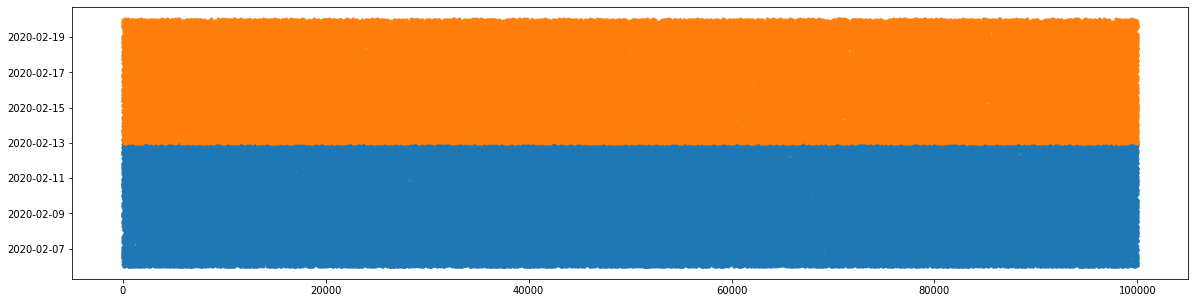

In [52]:
plt.figure(figsize=(20,5))
plt.plot(df.tm_dt, '.')
plt.plot(dfval.tm_dt, '.')

2020-02-09 11:44:27.062659584 2020-02-16 11:34:12.728294656


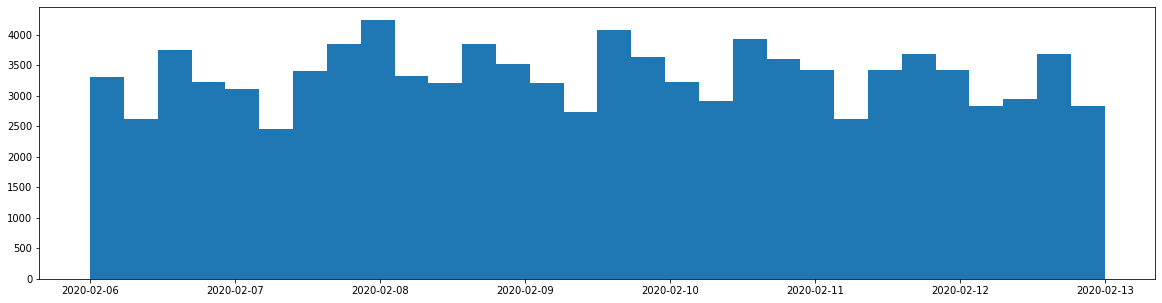

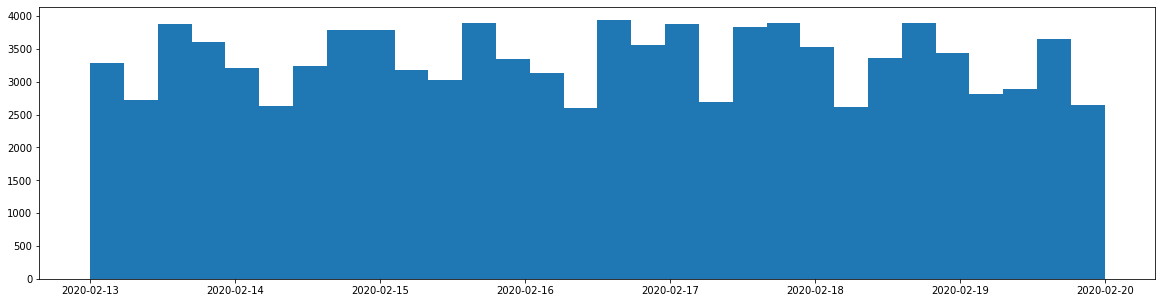

In [53]:
print(df.tm_dt.mean(), dfval.tm_dt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tm_dt,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tm_dt,30)
plt.show()

303331.93734 303946.2717


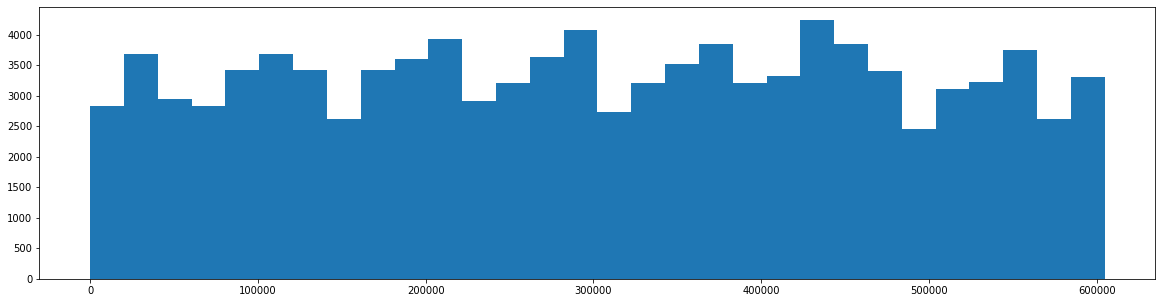

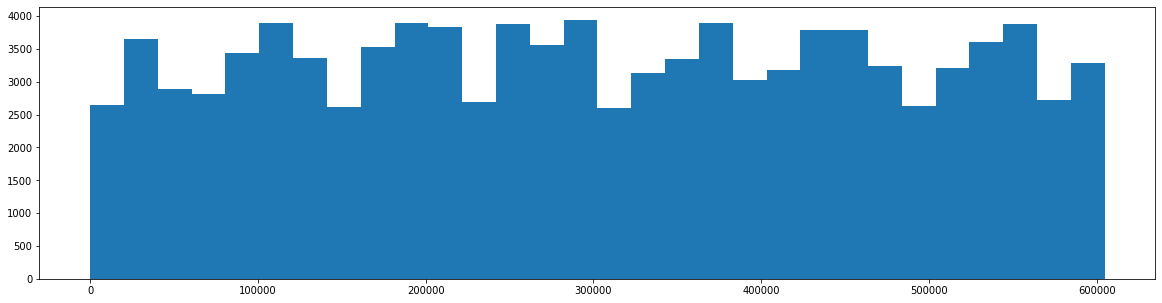

In [54]:
print(df.tmleft_twt.mean(),dfval.tmleft_twt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tmleft_twt,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tmleft_twt,30)
plt.show()

### v.s. target

In [48]:
df.groupby(['enged'])['tmleft_twt'].mean()

enged
False    299047.123855
True     307432.933870
Name: tmleft_twt, dtype: float64

## u1 create time

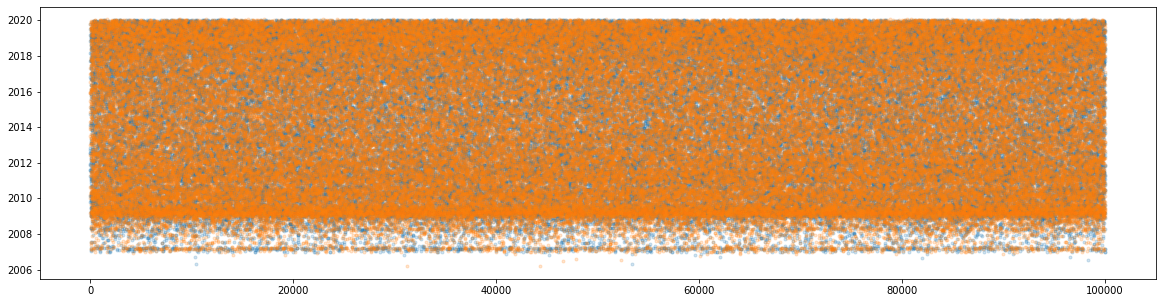

In [55]:
plt.figure(figsize=(20,5))
plt.plot(df.u1_create_tm_dt, '.', alpha=0.2)
plt.plot(dfval.u1_create_tm_dt, '.',alpha=0.2)

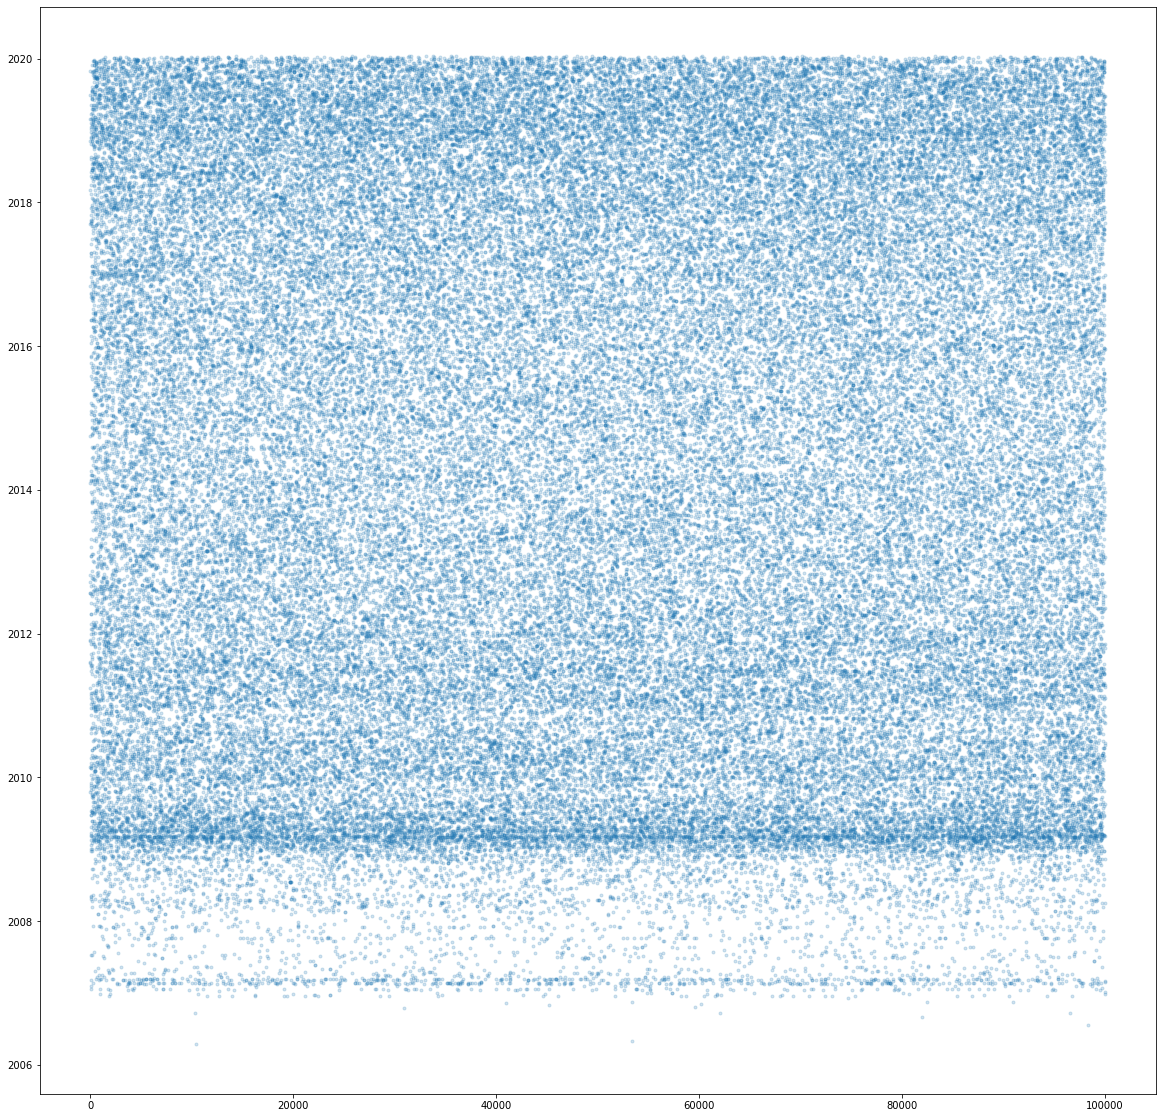

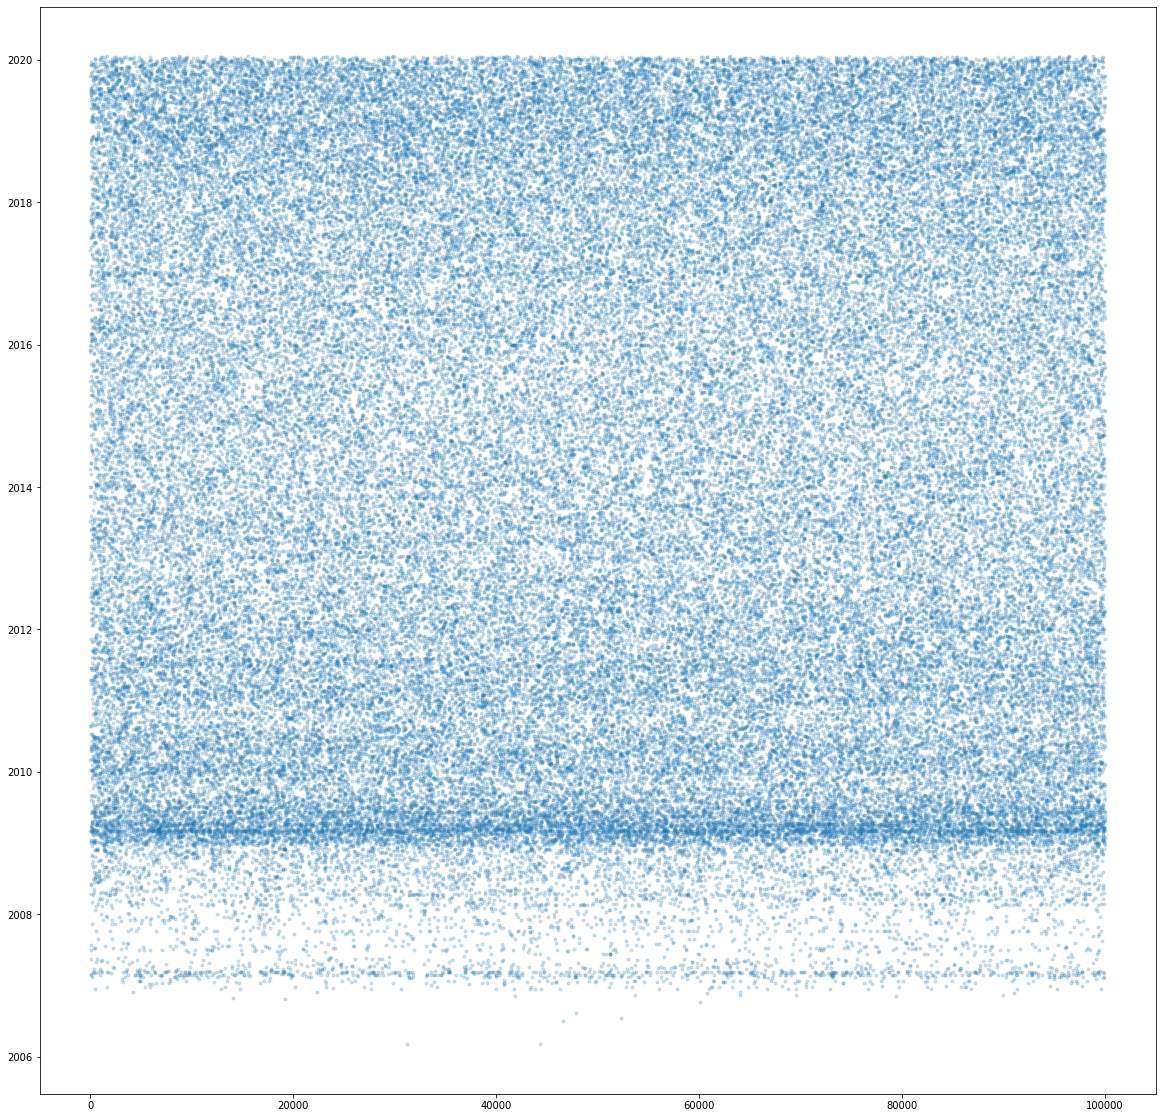

In [83]:
plt.figure(figsize=(20,20))
plt.plot(df.u1_create_tm_dt, '.', alpha=0.2)
plt.show()
plt.figure(figsize=(20,20))
plt.plot(dfval.u1_create_tm_dt, '.',alpha=0.2)
plt.show()

2014-04-19 04:56:18.880182016 2014-01-05 03:01:52.562584576


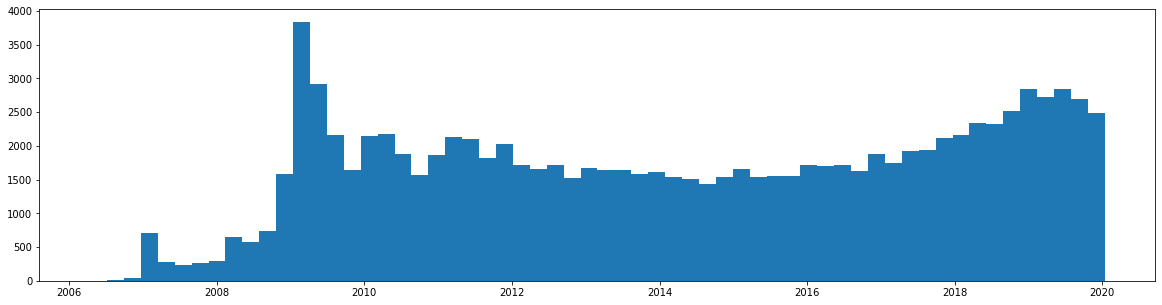

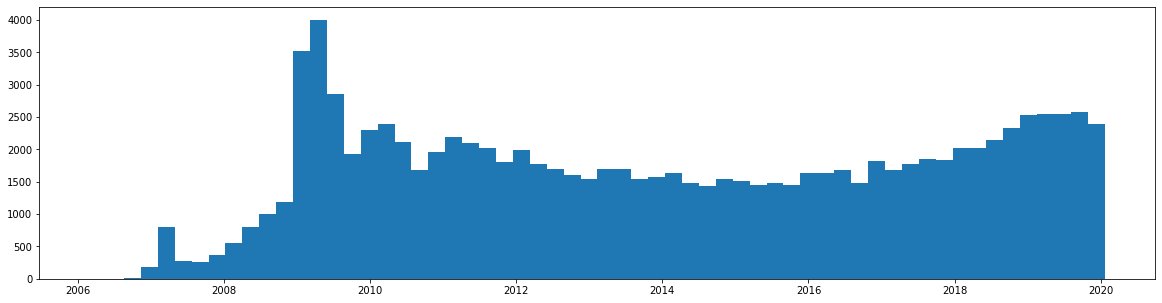

In [86]:
print(df.u1_create_tm_dt.mean(), dfval.u1_create_tm_dt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.u1_create_tm_dt,60)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.u1_create_tm_dt,60)
plt.show()

In [66]:
# user at least 30 days old 
print(df.tmleft_u1.min()/secs_per_day,dfval.tmleft_u1.min()/secs_per_day)

30.265011574074073 30.650497685185186


30.265011574074073 30.650497685185186
183668620.11983 193265886.43742


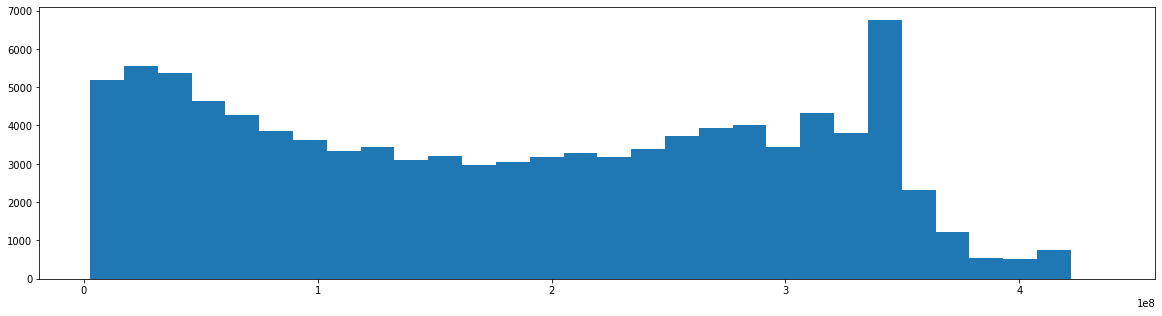

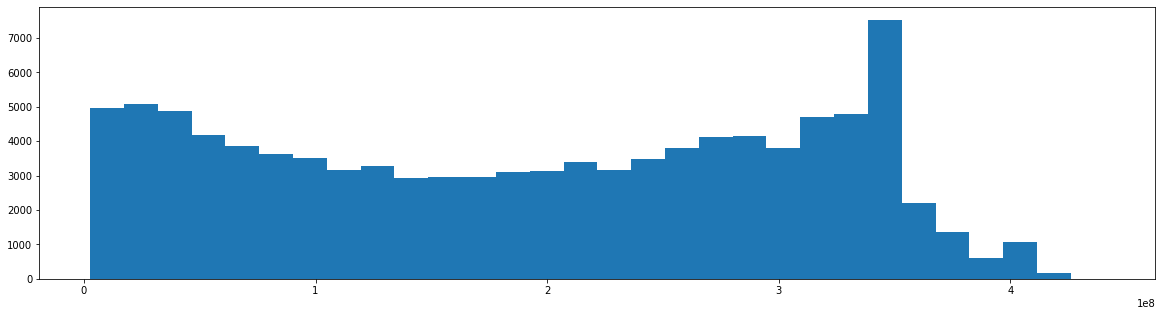

In [63]:
print(df.tmleft_u1.mean(),dfval.tmleft_u1.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tmleft_u1,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tmleft_u1,30)
plt.show()

### find that cutline

In [71]:
pd.set_option('display.max_rows', None)

In [76]:
df.u1_create_tm_dt.dt.year.value_counts().sort_index()

2006       69
2007     1634
2008     3290
2009    11404
2010     8240
2011     8814
2012     7295
2013     7078
2014     6613
2015     6985
2016     7383
2017     8570
2018    10438
2019    11925
2020      262
Name: u1_create_tm_dt, dtype: int64

In [96]:
df.u1_create_tm_dt.dt.date.value_counts().head()

2009-03-01    312
2009-04-06    156
2011-06-27    155
2007-02-21    145
2009-04-24    141
Name: u1_create_tm_dt, dtype: int64

In [81]:
df.u1_create_tm_dt.dt.date.value_counts().sort_index()

2006-04-14      1
2006-05-03      1
2006-07-19      1
2006-08-30      1
2006-09-23      3
2006-10-18      1
2006-10-23      1
2006-10-29      1
2006-11-06      1
2006-11-12      1
2006-11-14      1
2006-11-15      2
2006-12-08      1
2006-12-16     31
2006-12-22     11
2006-12-24      3
2006-12-25      6
2006-12-31      2
2007-01-02      3
2007-01-03      2
2007-01-04      1
2007-01-11      1
2007-01-15     31
2007-01-19      1
2007-01-20      9
2007-01-21      1
2007-01-23     51
2007-01-25      2
2007-01-28      1
2007-02-02      1
2007-02-03      9
2007-02-05      1
2007-02-06     13
2007-02-10      1
2007-02-12      1
2007-02-13     50
2007-02-16     20
2007-02-18      6
2007-02-20      1
2007-02-21    145
2007-02-22     22
2007-02-23     10
2007-02-24      2
2007-02-26      4
2007-02-27      2
2007-02-28      7
2007-03-01     12
2007-03-02      1
2007-03-03     20
2007-03-04      1
2007-03-05     19
2007-03-06      3
2007-03-07     14
2007-03-08      4
2007-03-09     30
2007-03-10

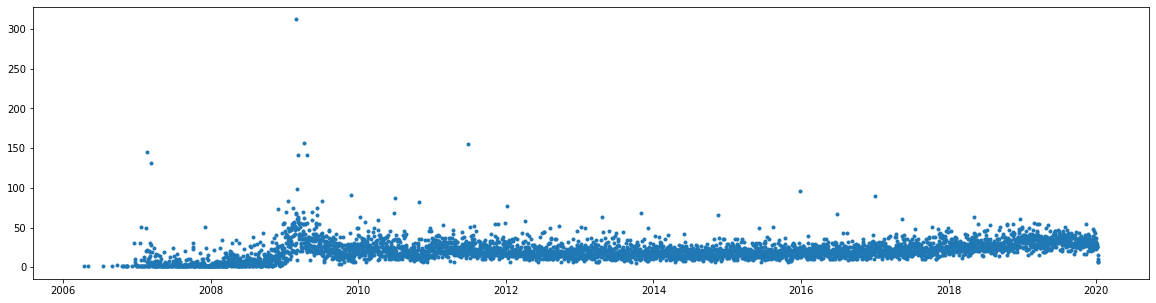

In [95]:
vc=df.u1_create_tm_dt.dt.date.value_counts()
plt.figure(figsize=(20,5))
plt.plot(vc.index,vc.values, '.')

In [109]:
early_u1=df.u1_create_tm_dt.dt.date<datetime.date(2009, 3, 1)#'2009-03-01'
early_u1.mean(), df.groupby(early_u1).enged.mean()

(0.07091,
 u1_create_tm_dt
 False    0.522576
 True     0.358765
 Name: enged, dtype: float64)

In [113]:
early_u1=df.u1_create_tm_dt.dt.date<datetime.date(2019, 3, 1)#'2009-03-01'
early_u1.mean(), df.groupby(early_u1).enged.mean()

(0.89822,
 u1_create_tm_dt
 False    0.638927
 True     0.496460
 Name: enged, dtype: float64)

### v.s. target

In [114]:
df.groupby(['enged'])['u1_create_tm'].mean()/3600/24/365 +1970

enged
False    2013.782251
True     2014.847579
Name: u1_create_tm, dtype: float64

In [115]:
df.groupby(['enged'])['tmleft_u1'].mean()/3600/24/365

enged
False    6.368434
True     5.303105
Name: tmleft_u1, dtype: float64

## u2 create time

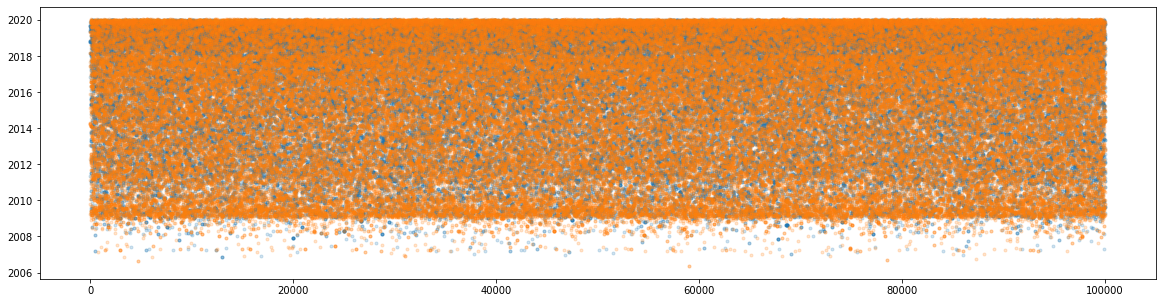

In [59]:
plt.figure(figsize=(20,5))
plt.plot(df.u2_create_tm_dt, '.', alpha=0.2)
plt.plot(dfval.u2_create_tm_dt, '.',alpha=0.2)

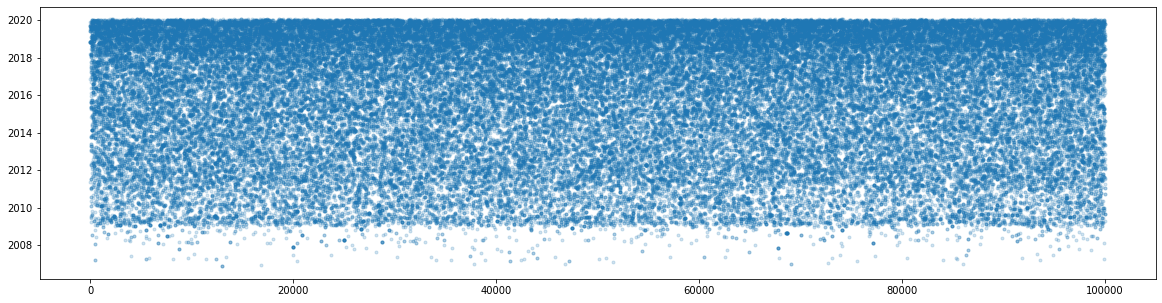

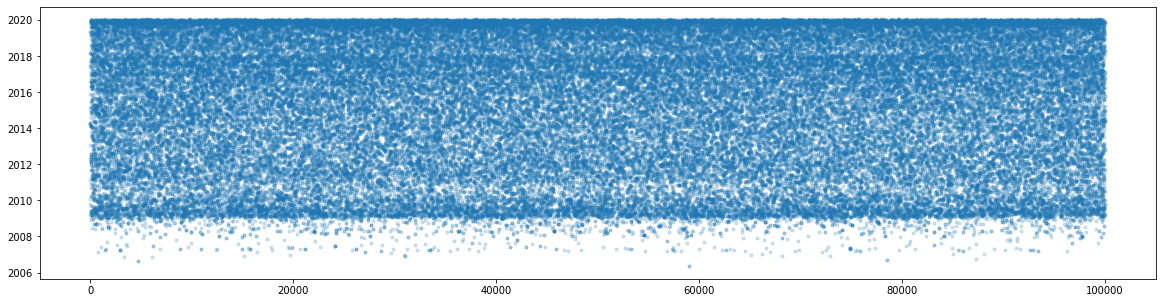

In [60]:
plt.figure(figsize=(20,5))
plt.plot(df.u2_create_tm_dt, '.', alpha=0.2)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(dfval.u2_create_tm_dt, '.',alpha=0.2)
plt.show()

2016-01-24 15:47:10.505008640 2015-04-18 10:20:51.868000768


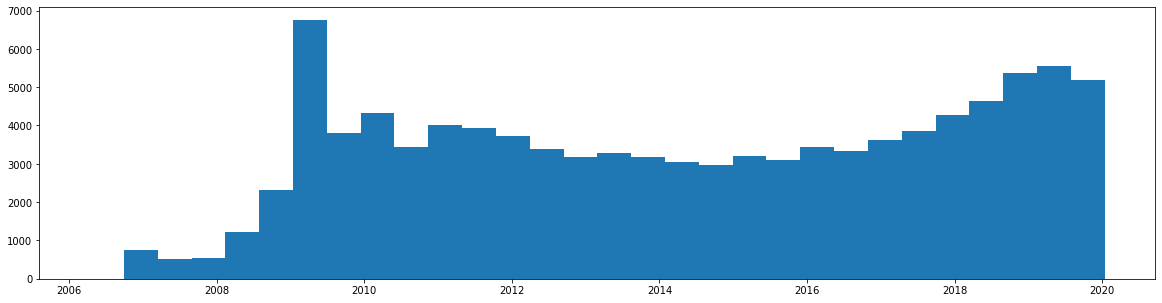

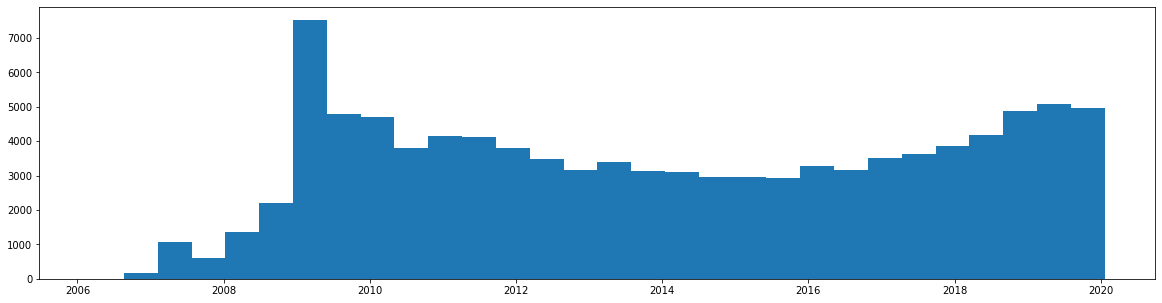

In [61]:
print(df.u2_create_tm_dt.mean(), dfval.u2_create_tm_dt.mean())
plt.figure(figsize=(20,5))
plt.hist(df.u1_create_tm_dt,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.u1_create_tm_dt,30)
plt.show()

In [65]:
# user at least 30 days old 
print(df.tmleft_u2.min()/secs_per_day,dfval.tmleft_u2.min()/secs_per_day)

30.003194444444443 31.019039351851852


30.003194444444446 31.01903935185185
127901568.49498 152804347.13202


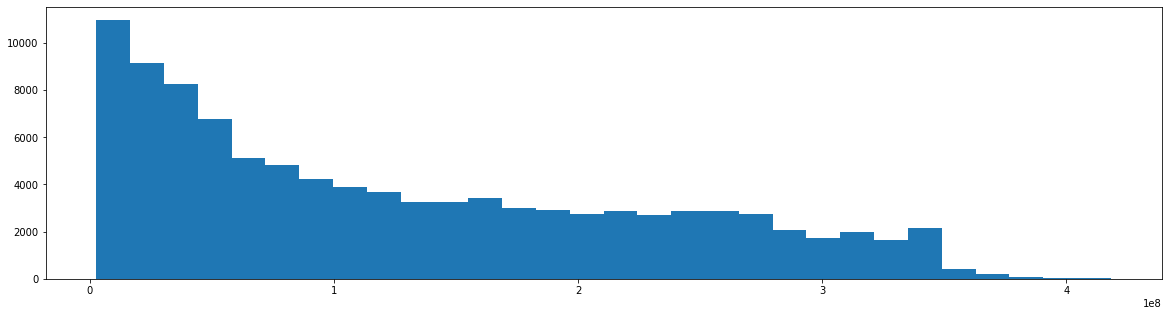

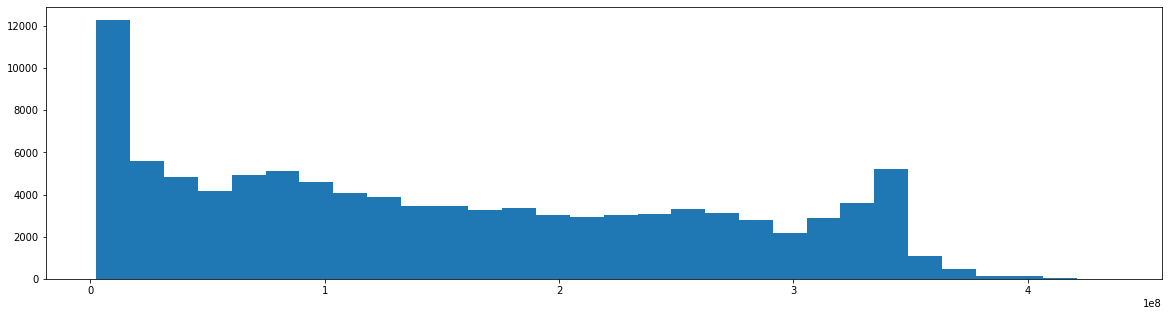

In [50]:
print(df.tmleft_u2.mean(),dfval.tmleft_u2.mean())
plt.figure(figsize=(20,5))
plt.hist(df.tmleft_u2,30)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(dfval.tmleft_u2,30)
plt.show()

### v.s. target

In [55]:
df.groupby(['enged'])['u2_create_tm'].mean()/3600/24/365

enged
False    45.863872
True     46.316120
Name: u2_create_tm, dtype: float64

In [52]:
df.groupby(['enged'])['tmleft_u2'].mean()/3600/24/365

enged
False    4.286813
True     3.834565
Name: tmleft_u2, dtype: float64

# twitid freq

# u1 freq

# u2 freq